In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
import matplotlib.pyplot as plt

In [3]:
from CarlaBEV.envs.utils import load_map

rgbmap, _, _ = load_map(size=1024)

print(f"Image Size: {rgbmap.shape}")

Image Size: (10240, 8192, 3)


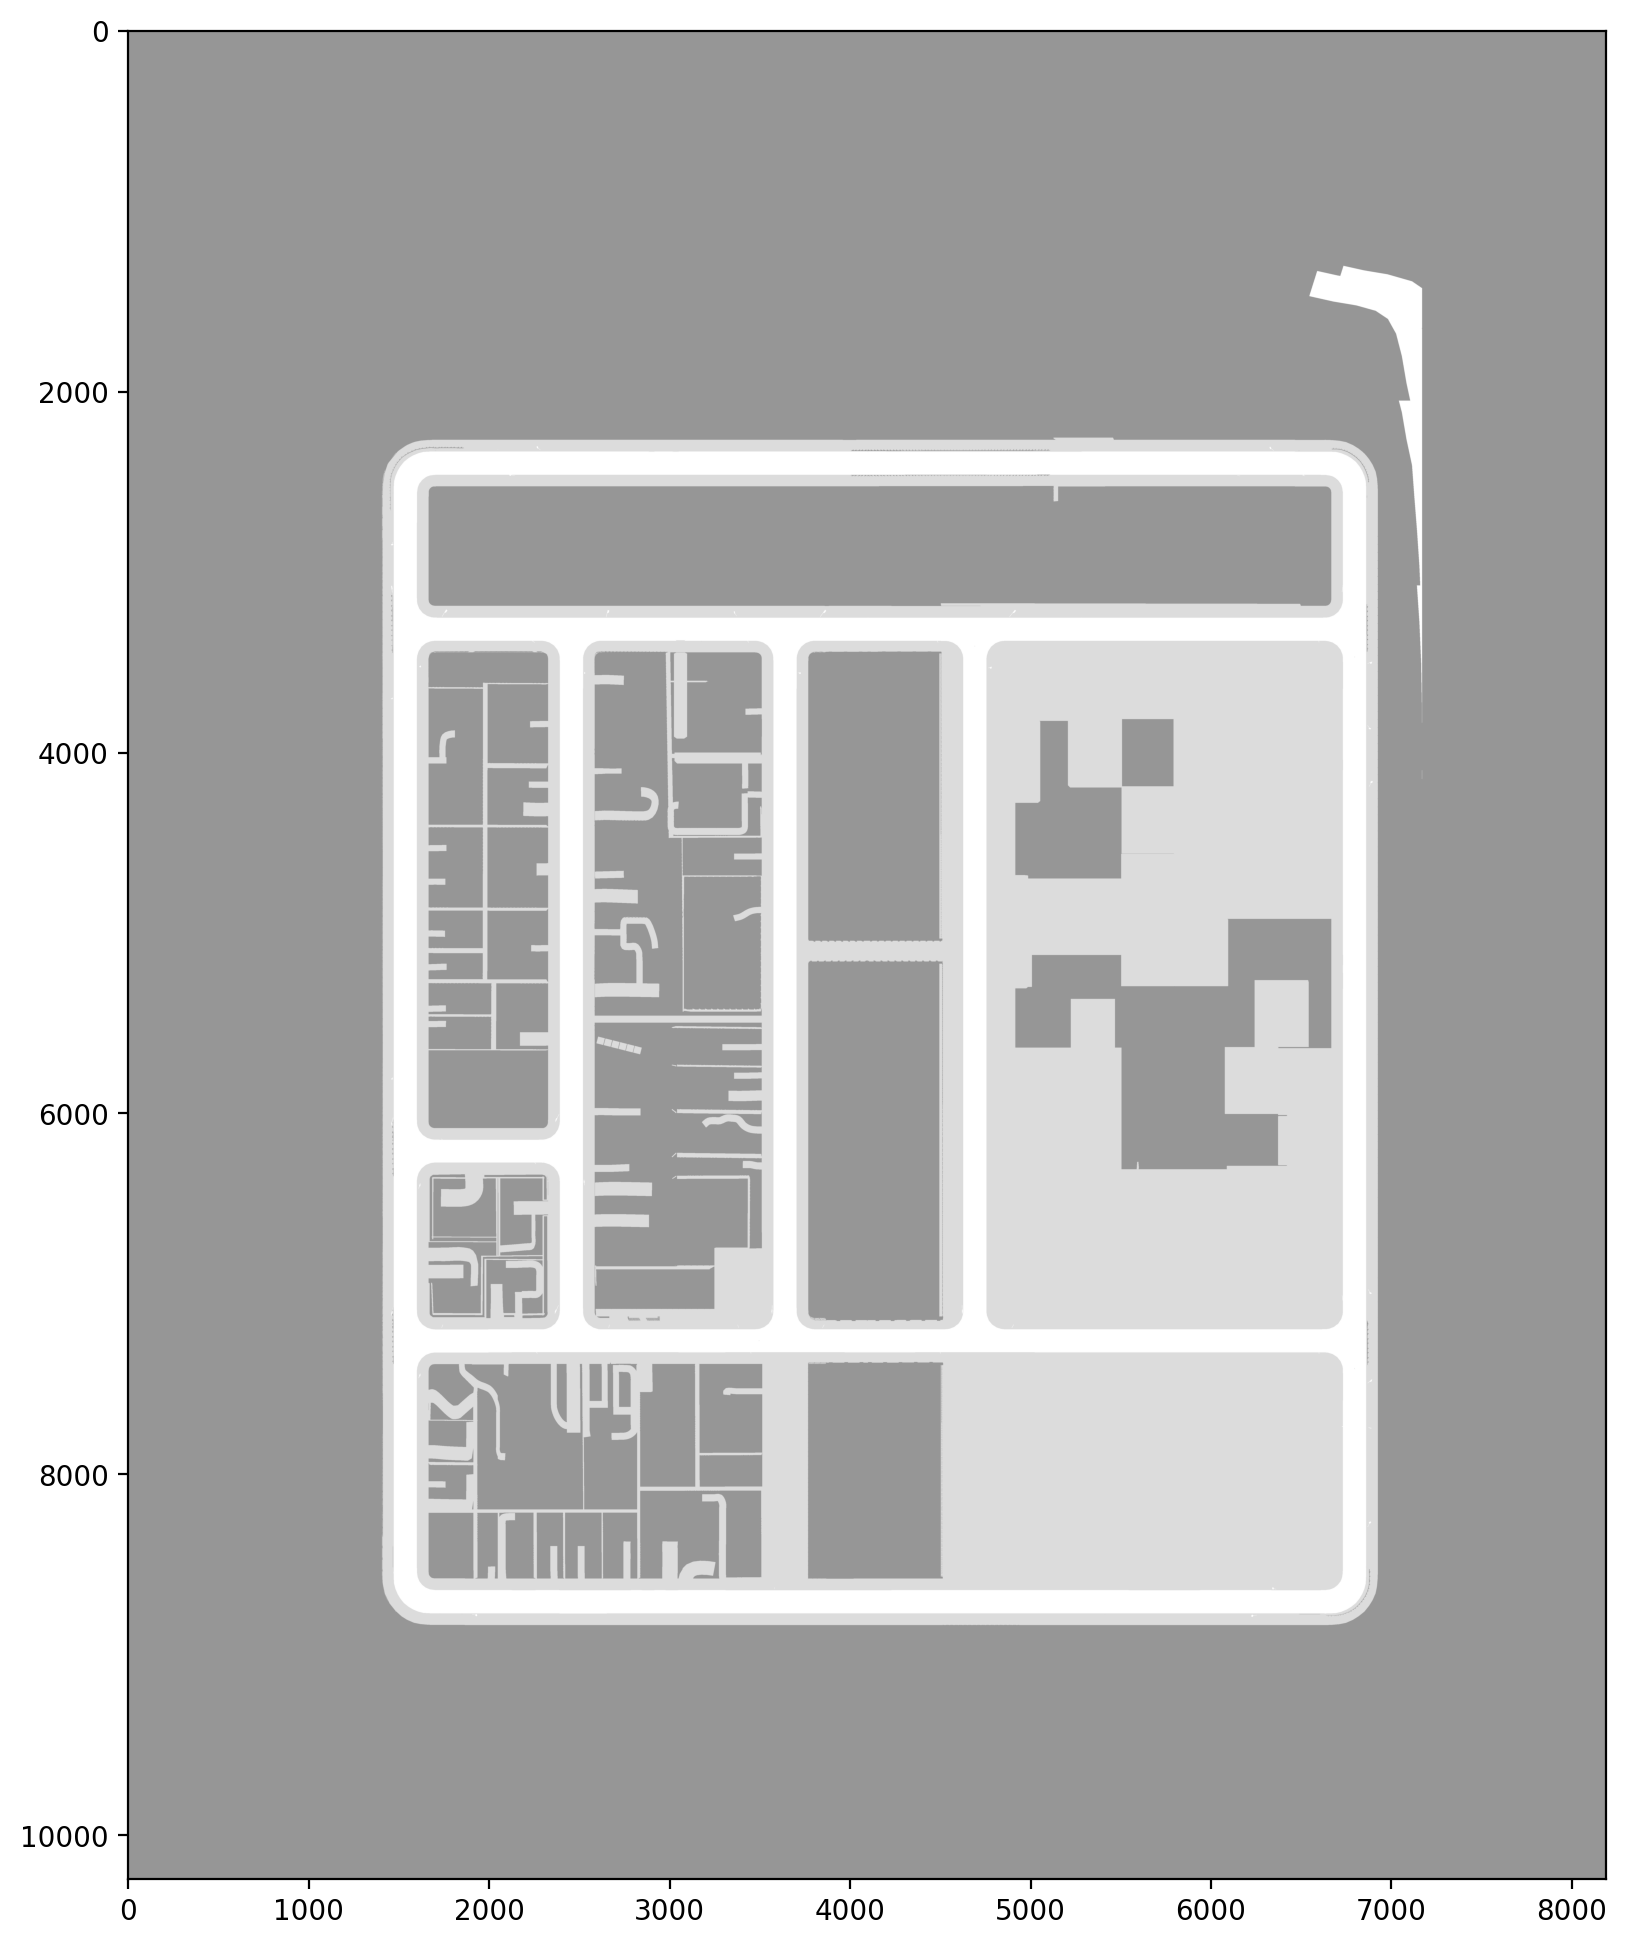

In [4]:
# Check map
plt.imshow(rgbmap)
plt.show()

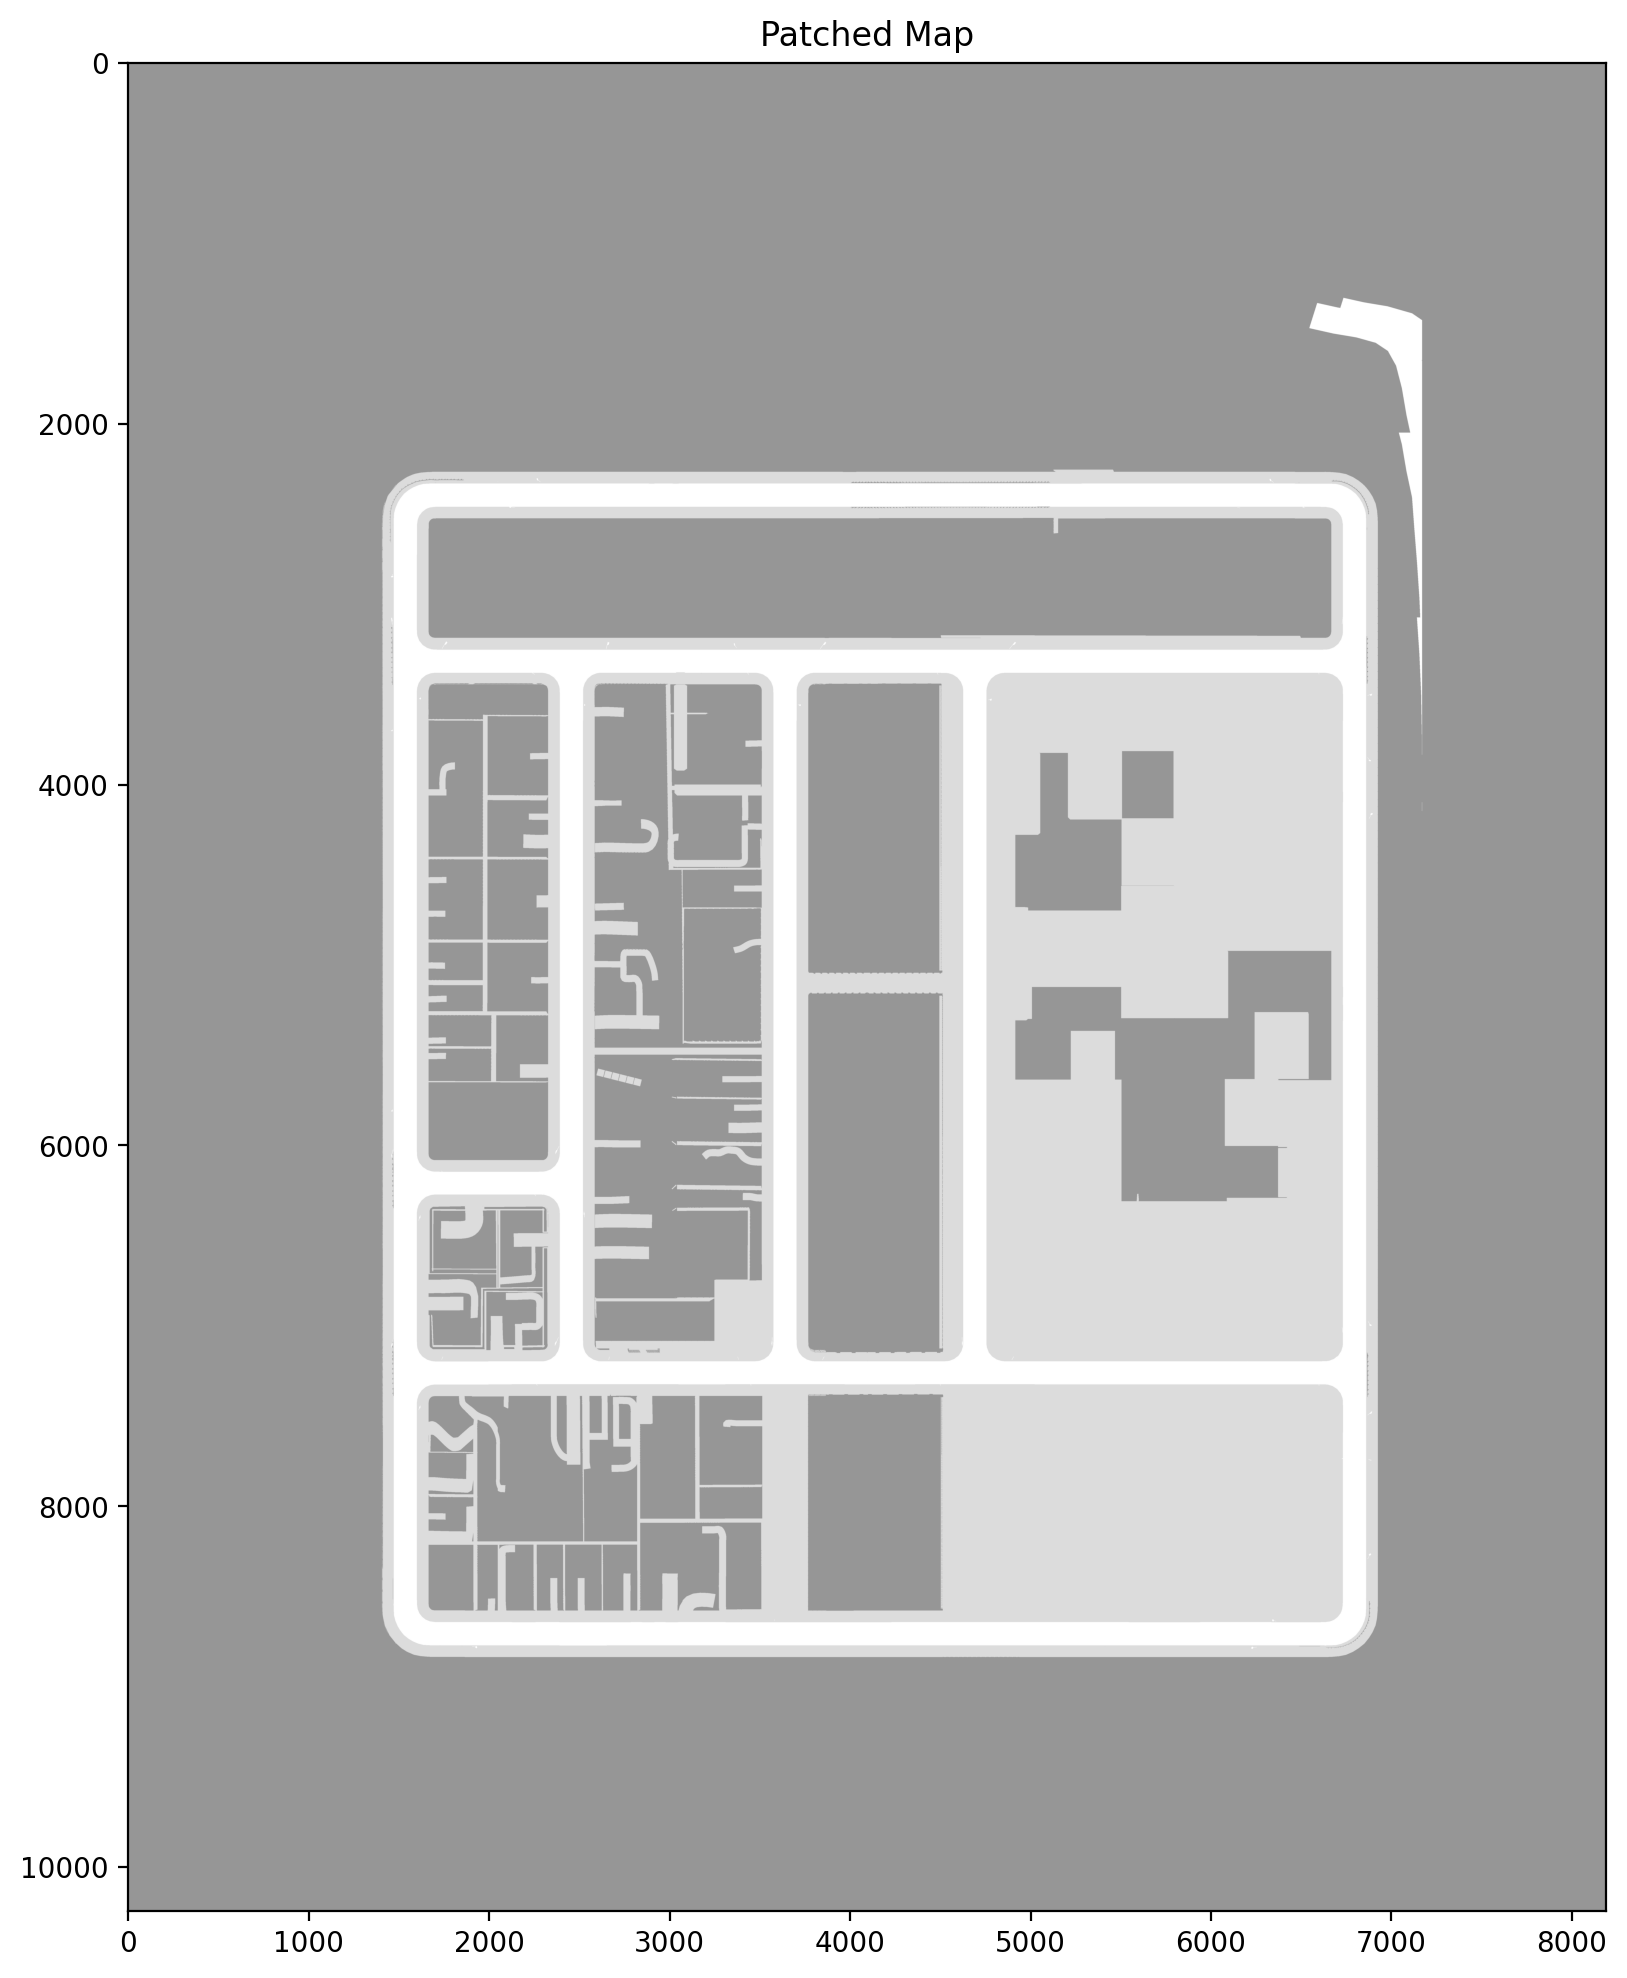

In [5]:
# Example: Patch a white rectangle at (y0, x0) with height h and width w

# If rgbmap is float [0,1], use 1.0; if uint8 [0,255], use 255
if rgbmap.dtype == np.uint8:
    white = 255
else:
    white = 1.0

y0, x0 = 7409, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3466, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 7256, 3492    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3406, 4689    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

plt.imshow(rgbmap)
plt.title("Patched Map")
plt.show()

In [6]:
intersections = [
    (8642, 1564),
    (8654, 6755),
    (7250, 1552),
    (7241, 2446),
    (7242, 3652),
    (7242, 4704),
    (7257, 6773),
    (6199, 1552),
    (6197, 2439),
    (3349, 1545),
    (3350, 2456),
    (3350, 3639),
    (3335, 4714),
    (3315, 6773),
    (2456, 1563),
    (2446, 6757),
 ]

intersections = [(y, x) for x, y in intersections]

In [43]:
map_edges = {}
for i, coord in enumerate(intersections):
    x, y = coord
    map_edges[i] = (x, y)

In [7]:
from skimage.color import rgb2gray
from skimage.morphology import skeletonize

def get_midlane_coords(rgbmap):
    gray = rgb2gray(rgbmap)
    binary = gray > 0.99  # Adjust threshold if needed
    # Skeletonize to get lane centerlines
    skeleton = skeletonize(binary)
    # Get coordinates of skeleton pixels (centerline points)
    centerline_coords = np.argwhere(skeleton)
    return centerline_coords

def sample_equidistant_points(path_coords, step=100):
    """Given a list of (y, x) coords, return equidistant points along the path."""
    path_coords = np.array(path_coords)
    # Compute cumulative distance along the path
    deltas = np.diff(path_coords, axis=0)
    dists = np.sqrt((deltas**2).sum(axis=1))
    cumdist = np.insert(np.cumsum(dists), 0, 0)
    total_dist = cumdist[-1]
    n_points = int(total_dist // step)
    if n_points < 2:
        return path_coords  # Path too short, return as is
    sample_dists = np.linspace(0, total_dist, n_points)
    sampled_points = np.empty((n_points, 2))
    sampled_points[0] = path_coords[0]
    sampled_points[-1] = path_coords[-1]
    j = 1
    for i in range(1, n_points-1):
        d = sample_dists[i]
        while cumdist[j] < d:
            j += 1
        ratio = (d - cumdist[j-1]) / (cumdist[j] - cumdist[j-1])
        sampled_points[i] = path_coords[j-1] + ratio * (path_coords[j] - path_coords[j-1])
    return sampled_points.astype(int)

def get_route_waypoints(pixel_graph, node_a, node_b ):
    # 2. For each consecutive pair, find pixel path and discretize
    pixel_path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(pixel_path, step=300)  # step in pixels
    return waypoints

def compute_lane_offsets(waypoints, lane_width=6.0):
    """
    Given centerline waypoints (N,2), return left and right lane waypoints.
    lane_width: total width of both lanes (in pixels, adjust as needed)
    """
    waypoints = np.array(waypoints)
    left_lane = []
    right_lane = []
    side_1, side_2 = [], []
    offset = lane_width / 2.0
    offset_ped = lane_width + 10

    for i in range(len(waypoints)):
        # Compute direction vector
        if i == 0:
            direction = waypoints[i+1] - waypoints[i]
        elif i == len(waypoints) - 1:
            direction = waypoints[i] - waypoints[i-1]
        else:
            direction = waypoints[i+1] - waypoints[i-1]
        direction = direction / np.linalg.norm(direction)
        # Normal vector (perpendicular, 2D)
        normal = np.array([-direction[1], direction[0]])
        # Offset points
        left_lane.append(waypoints[i] + offset * normal)
        right_lane.append(waypoints[i] - offset * normal)
        side_1.append(waypoints[i] + offset_ped * normal)
        side_2.append(waypoints[i] - offset_ped * normal)
    return np.array(left_lane), np.array(right_lane), np.array(side_1), np.array(side_2)


In [8]:
def show_route(rgbmap, waypoints):
    # 3. Visualize the full route
    plt.imshow(rgbmap)
    for idx, p in enumerate(intersections):
        plt.scatter(p[1], p[0], c='red', s=80, zorder=3)
        plt.annotate(str(idx), (p[1], p[0]), color='k', fontsize=12, weight='bold', zorder=4)
    plt.plot(waypoints[:,1], waypoints[:,0], 'orange', lw=2, zorder=5, label='Discretized Route')
    plt.scatter(waypoints[:,1], waypoints[:,0], c='b', s=1, zorder=6, label='Waypoints')
    plt.axis('off')
    plt.legend()
    plt.show()

In [9]:
centerline_coords = get_midlane_coords(rgbmap)
centerline_coords = centerline_coords[:, [1, 0]]

In [10]:
# 1. Find the closest centerline point for each intersection
intersection_nodes = []
for intersection in intersections:
    dists = np.linalg.norm(centerline_coords - intersection, axis=1)
    idx_min = np.argmin(dists)
    intersection_nodes.append(tuple(centerline_coords[idx_min]))

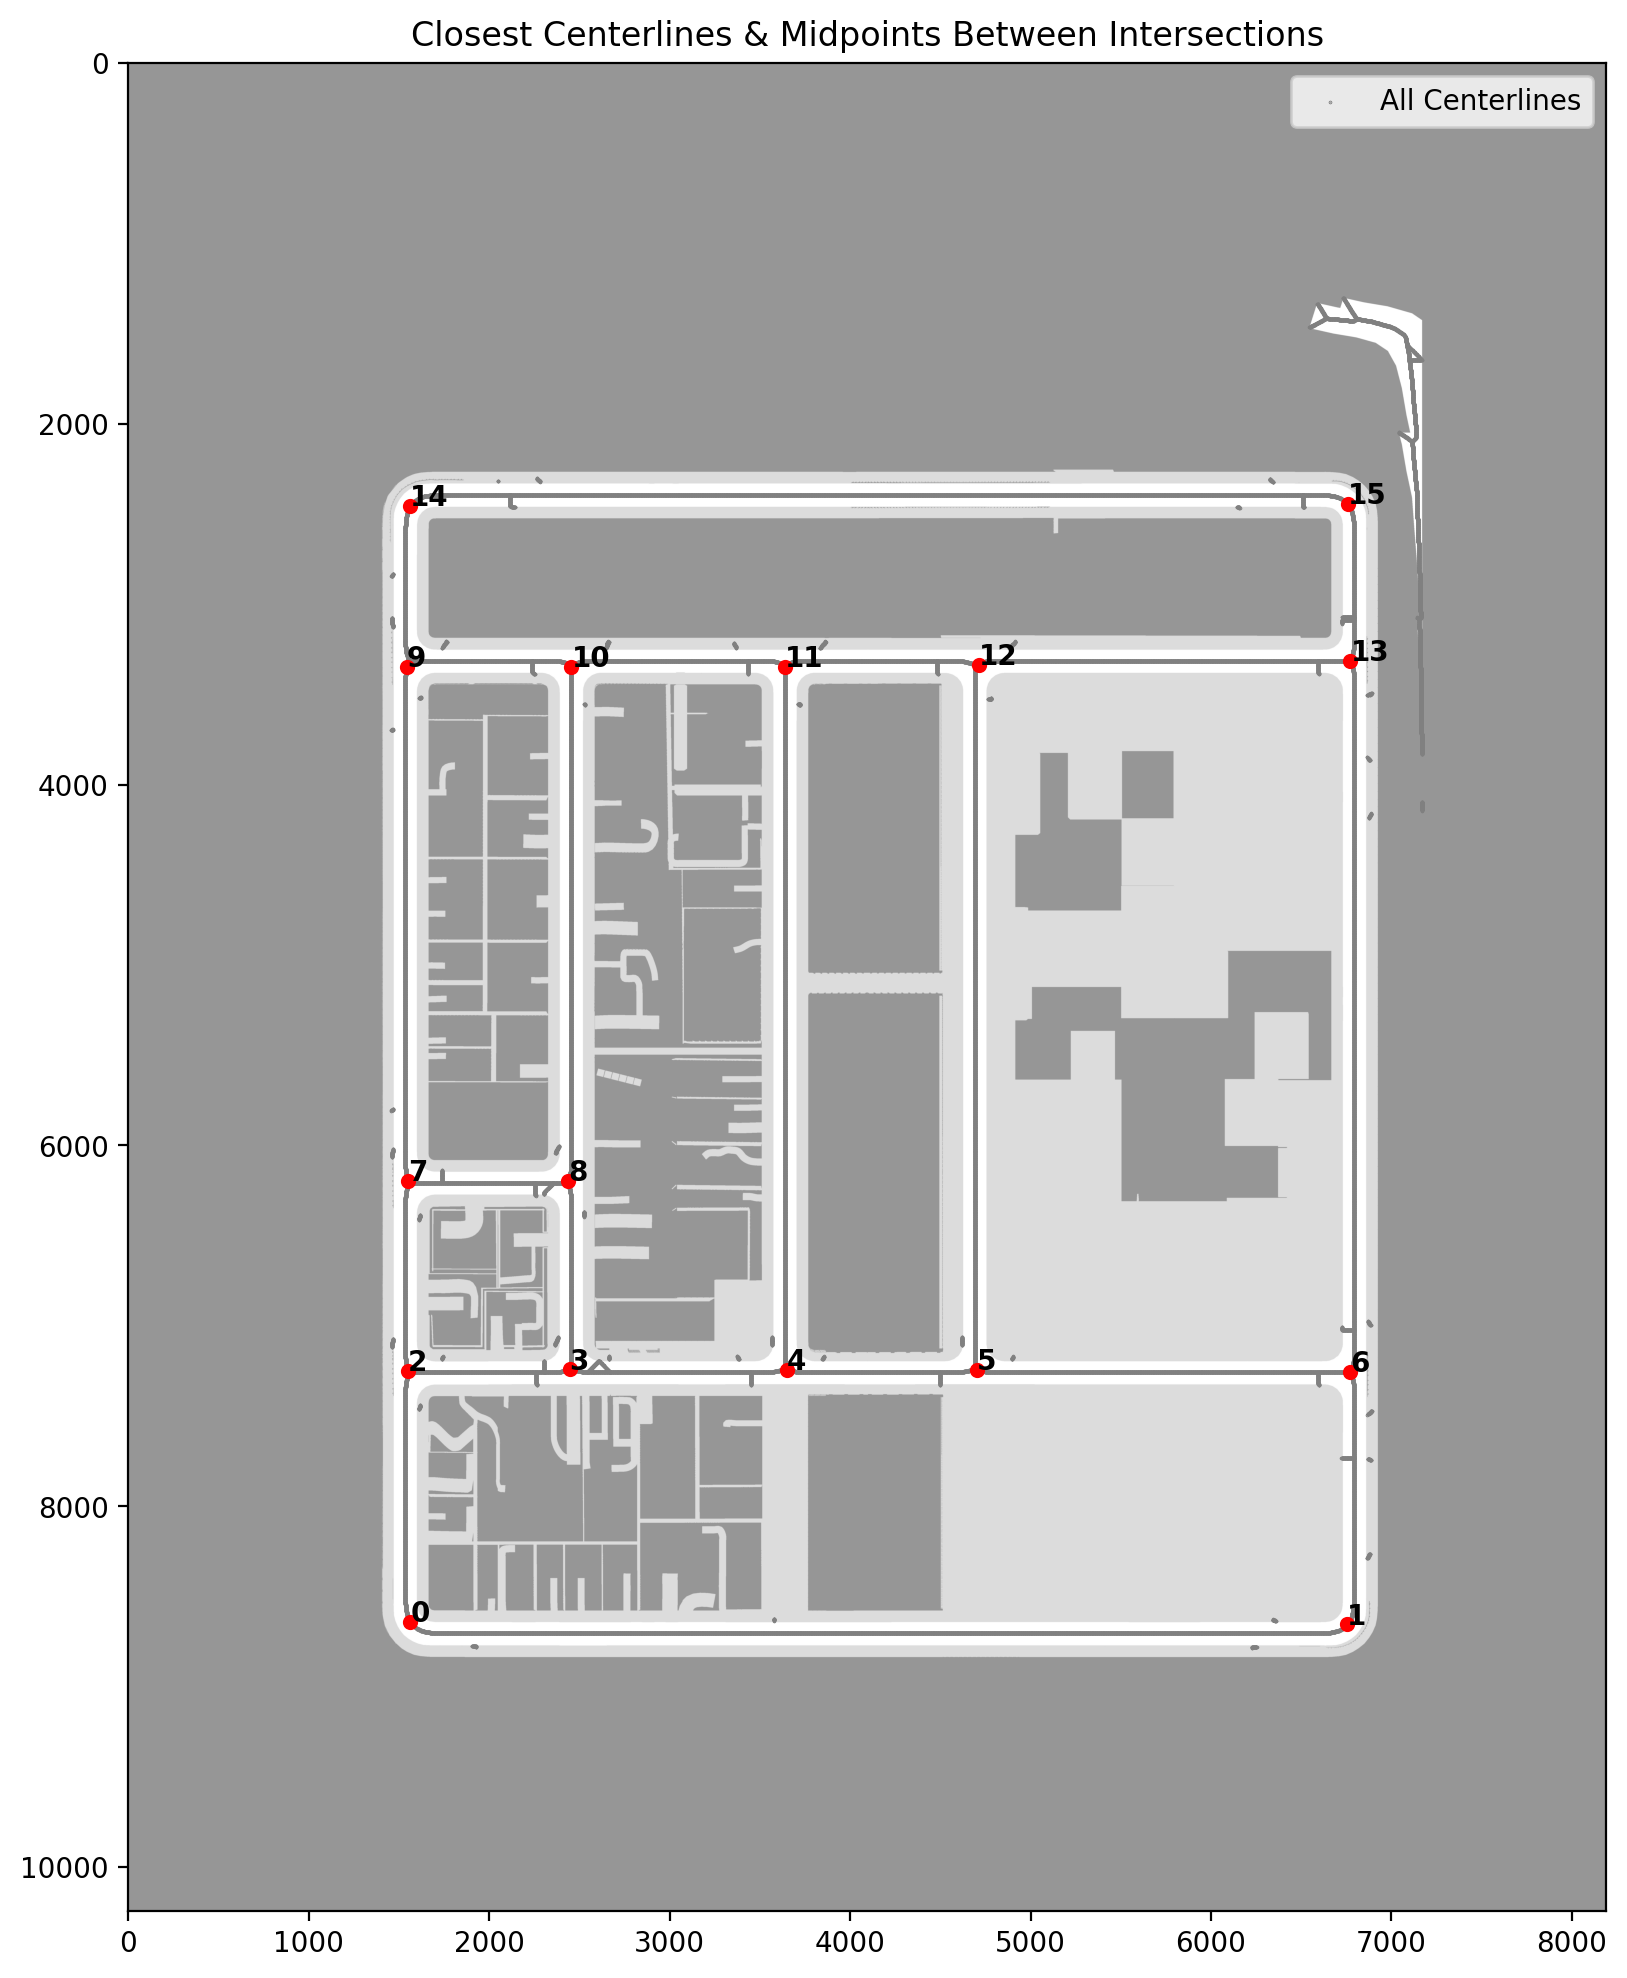

In [11]:
plt.imshow(rgbmap)
plt.scatter(centerline_coords[:,0], centerline_coords[:,1], c='gray', s=0.1, label='All Centerlines')
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
plt.legend()
plt.title("Closest Centerlines & Midpoints Between Intersections")
plt.show()

Direct intersection pairs (by index): [(0, 1), (0, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 11), (5, 6), (5, 12), (6, 13), (7, 8), (7, 9), (8, 10), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13), (13, 15), (14, 15)]


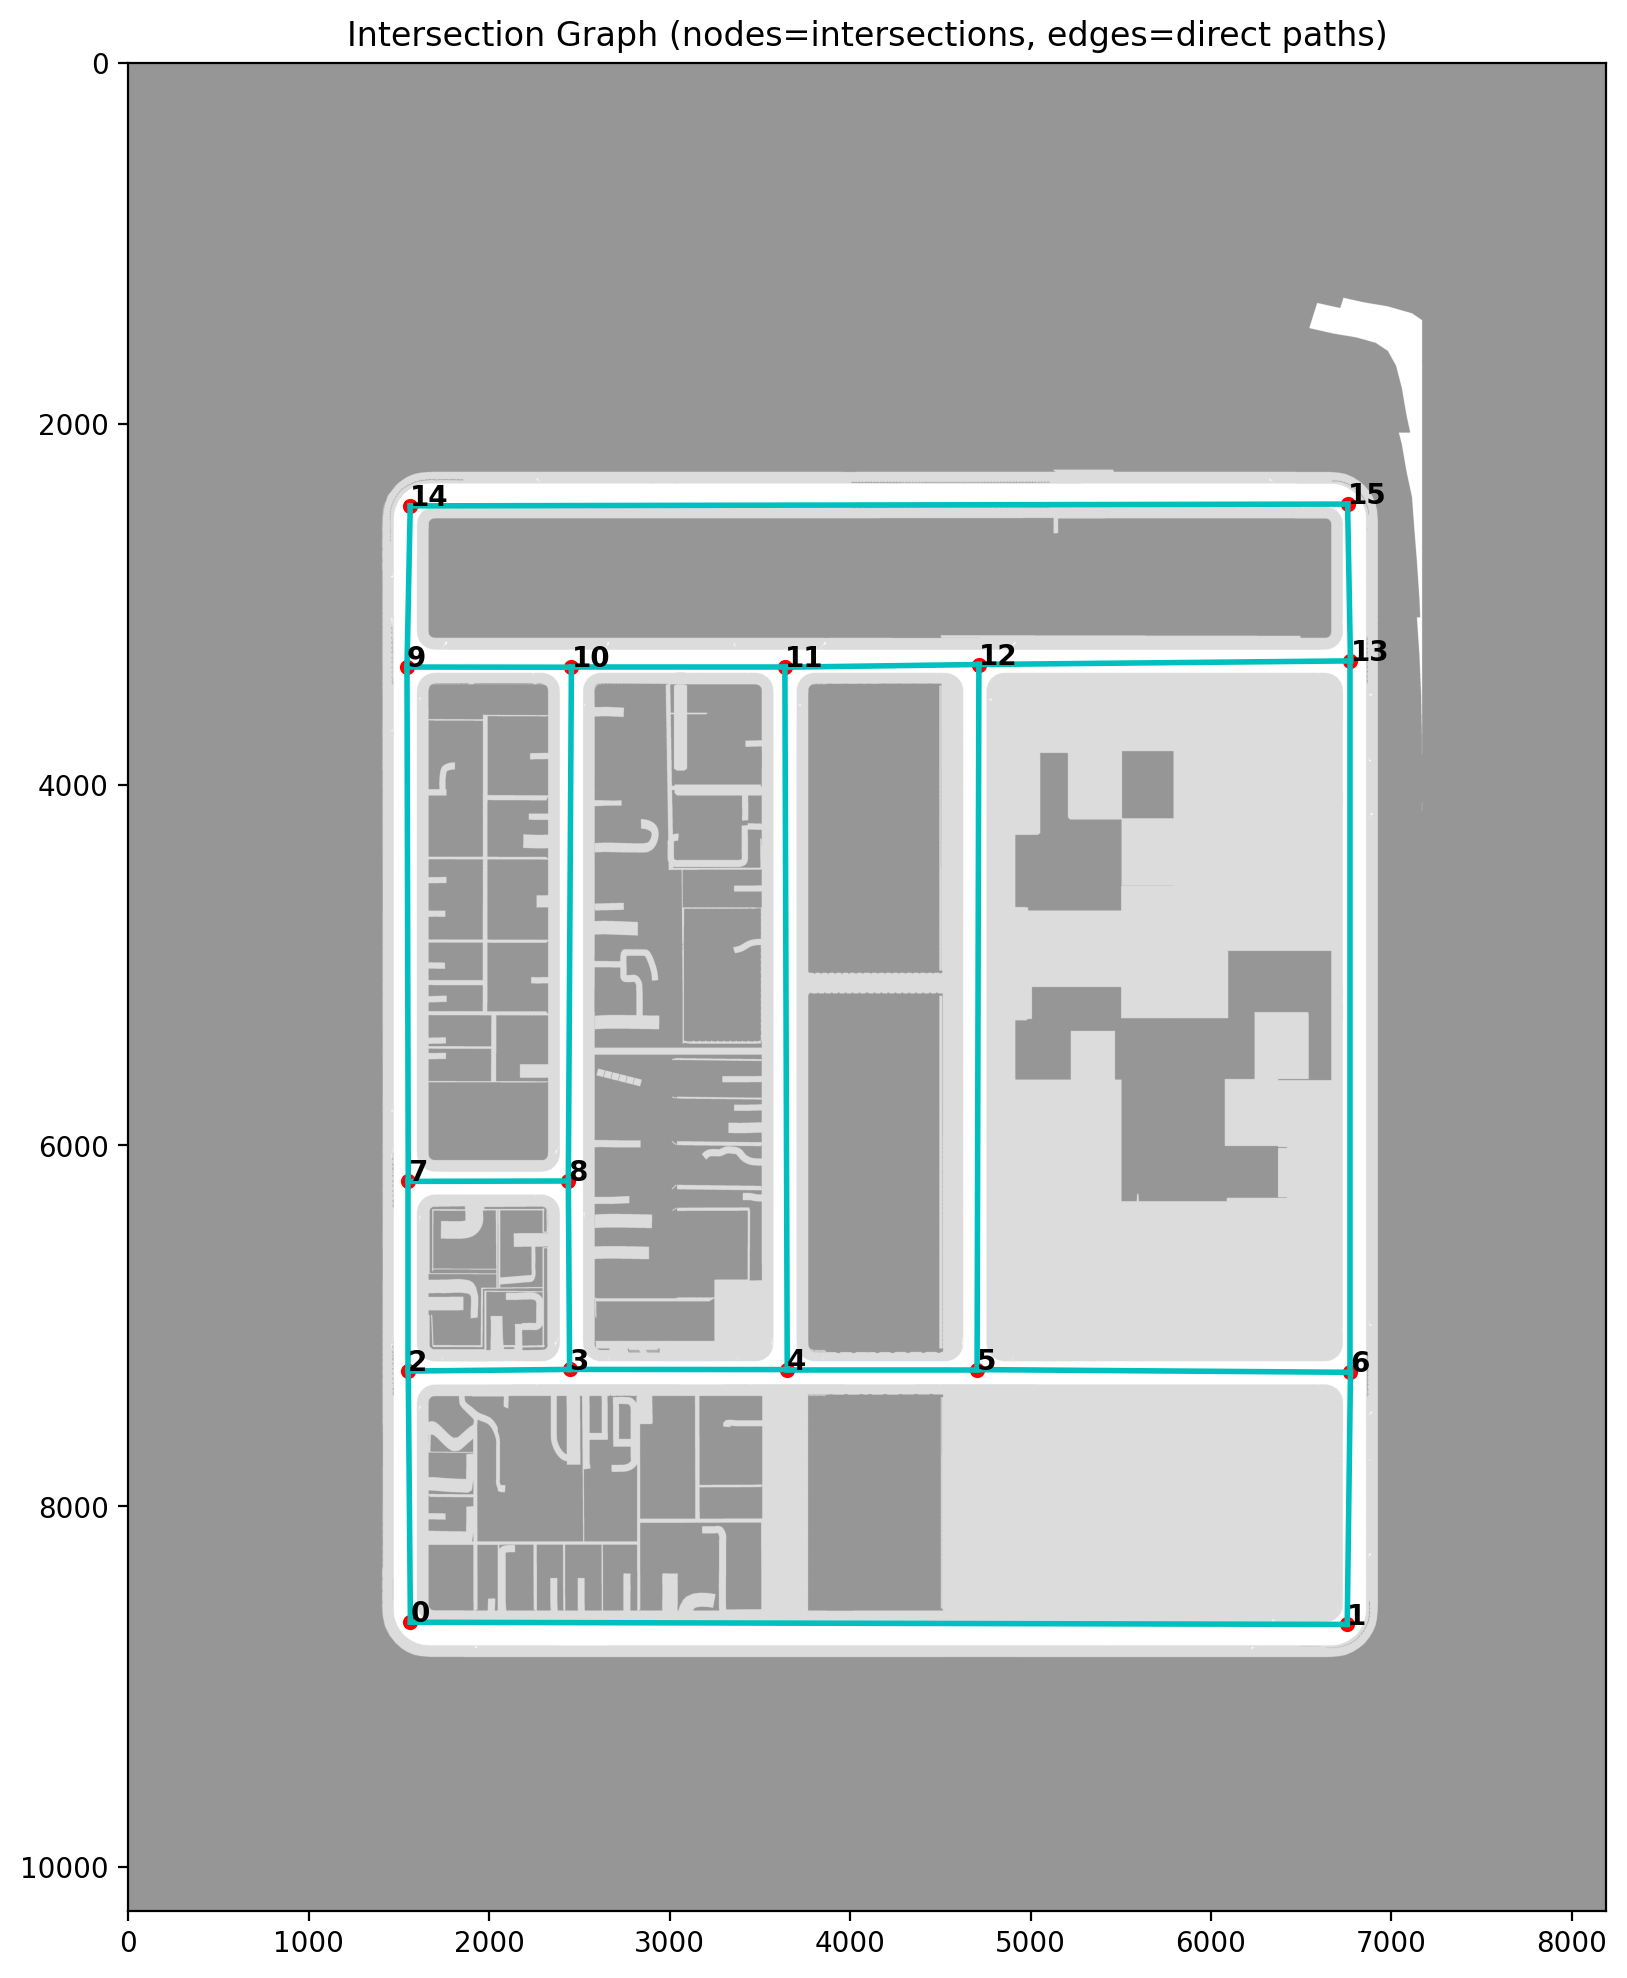

In [12]:
# 2. Build a pixel adjacency graph for centerline_coords (for pathfinding only)
pixel_graph = nx.Graph()
centerline_set = set(map(tuple, centerline_coords))
for y, x in centerline_coords:
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = (y + dy, x + dx)
            if neighbor in centerline_set:
                pixel_graph.add_edge((y, x), neighbor)

# 3. Precompute a set of "blocked" pixels for each intersection (within a radius)
block_radius = 100  # pixels
blocked_pixels = []
for node in intersection_nodes:
    y0, x0 = node
    pixels = set()
    for dy in range(-block_radius, block_radius+1):
        for dx in range(-block_radius, block_radius+1):
            if dy**2 + dx**2 <= block_radius**2:
                pixels.add((y0+dy, x0+dx))
    blocked_pixels.append(pixels)

# 4. Build the intersection graph
G_intersections = nx.Graph()
for idx in range(len(intersections)):
    G_intersections.add_node(idx, pos=intersections[idx])

for i, node_a in enumerate(intersection_nodes):
    for j, node_b in enumerate(intersection_nodes):
        if i < j:
            try:
                path = nx.shortest_path(pixel_graph, node_a, node_b)
                path_set = set(path[1:-1])
                blocked = False
                for k, block in enumerate(blocked_pixels):
                    if k != i and k != j and path_set & block:
                        blocked = True
                        break
                if not blocked:
                    G_intersections.add_edge(i, j)
            except nx.NetworkXNoPath:
                continue

print("Direct intersection pairs (by index):", list(G_intersections.edges))

# Visualization
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
for i, j in G_intersections.edges:
    a = intersections[i]
    b = intersections[j]
    plt.plot([a[0], b[0]], [a[1], b[1]], 'c-', lw=2)
plt.title("Intersection Graph (nodes=intersections, edges=direct paths)")
plt.show()

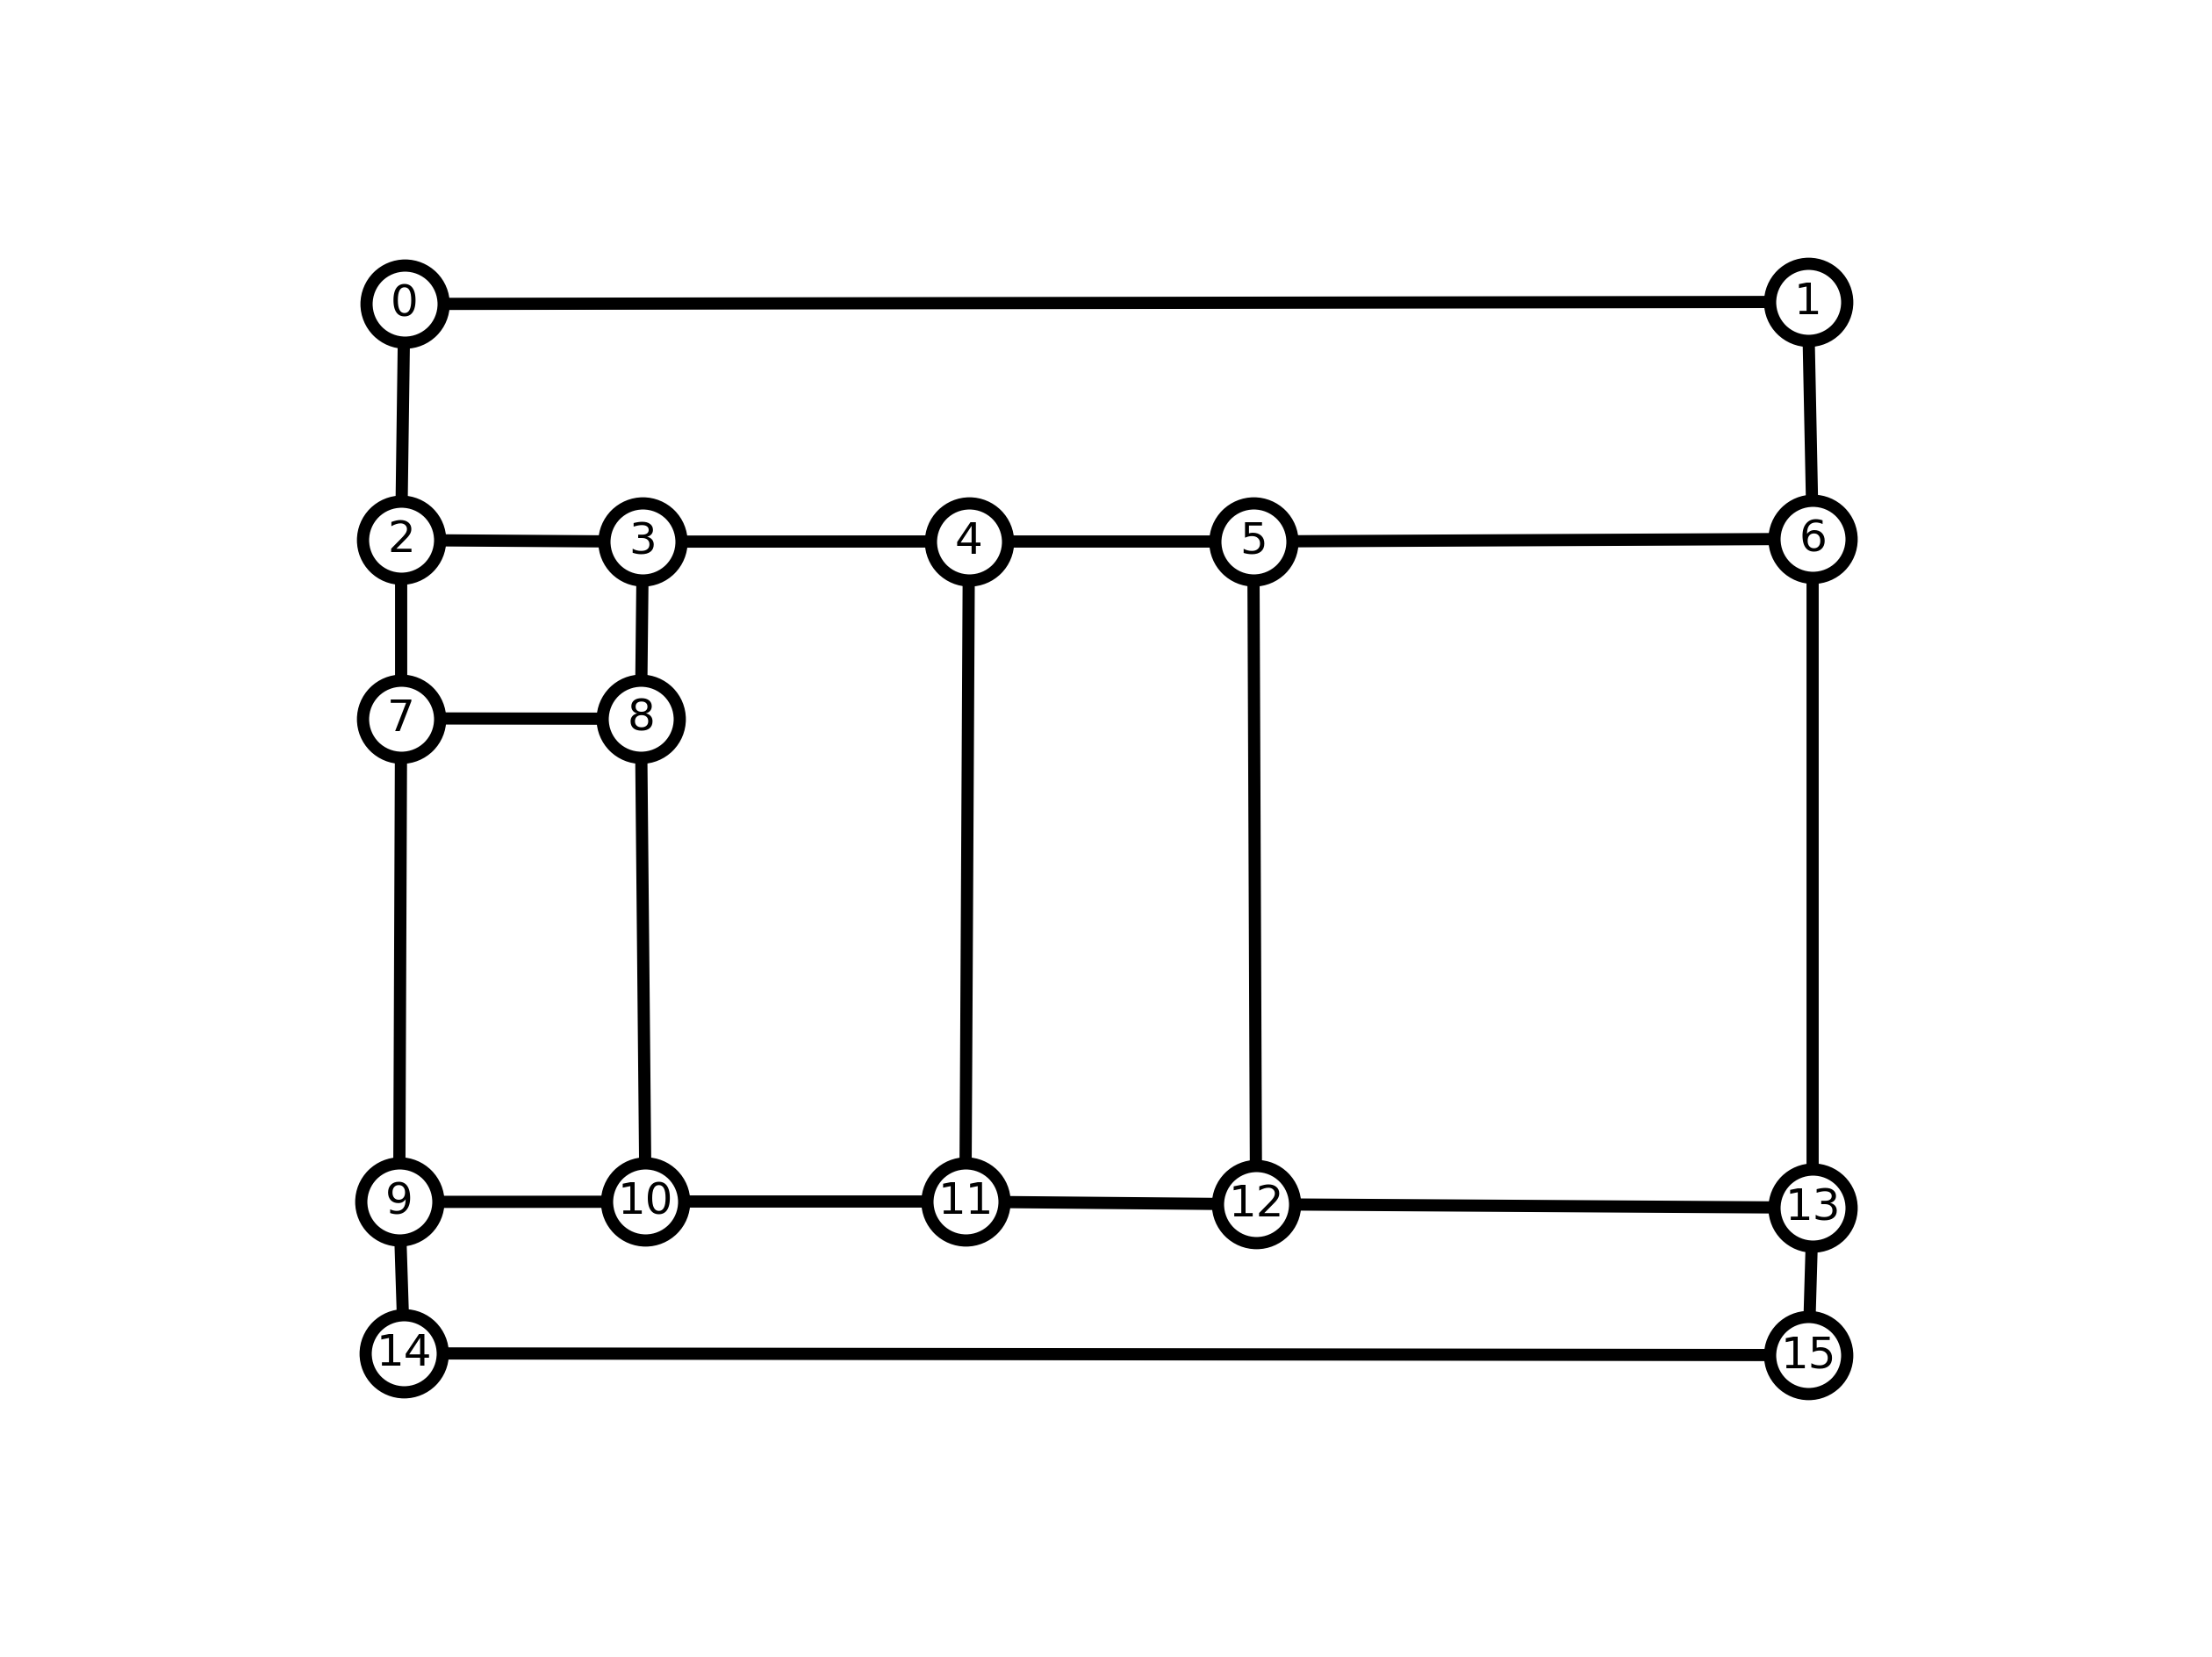

In [ ]:
options = {
    "font_size": 18,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(G_intersections, map_edges, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [13]:
# Usage
lane_width_pixels = 80  # Adjust to your map's scale

# Example: Discretize all edges in G_intersections
edge_waypoints = {}
edge_lanes_r = {}
edge_lanes_l = {}
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
    # Get the pixel path between intersections
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    # Sample equidistant points (e.g., every n pixels)
    waypoints = sample_equidistant_points(path, step=100)

    left_lane, right_lane, side1, side2 = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)
    edge_waypoints[(i, j)] = waypoints
    edge_lanes_r[(i, j)] = right_lane 
    edge_lanes_l[(i, j)] = left_lane 

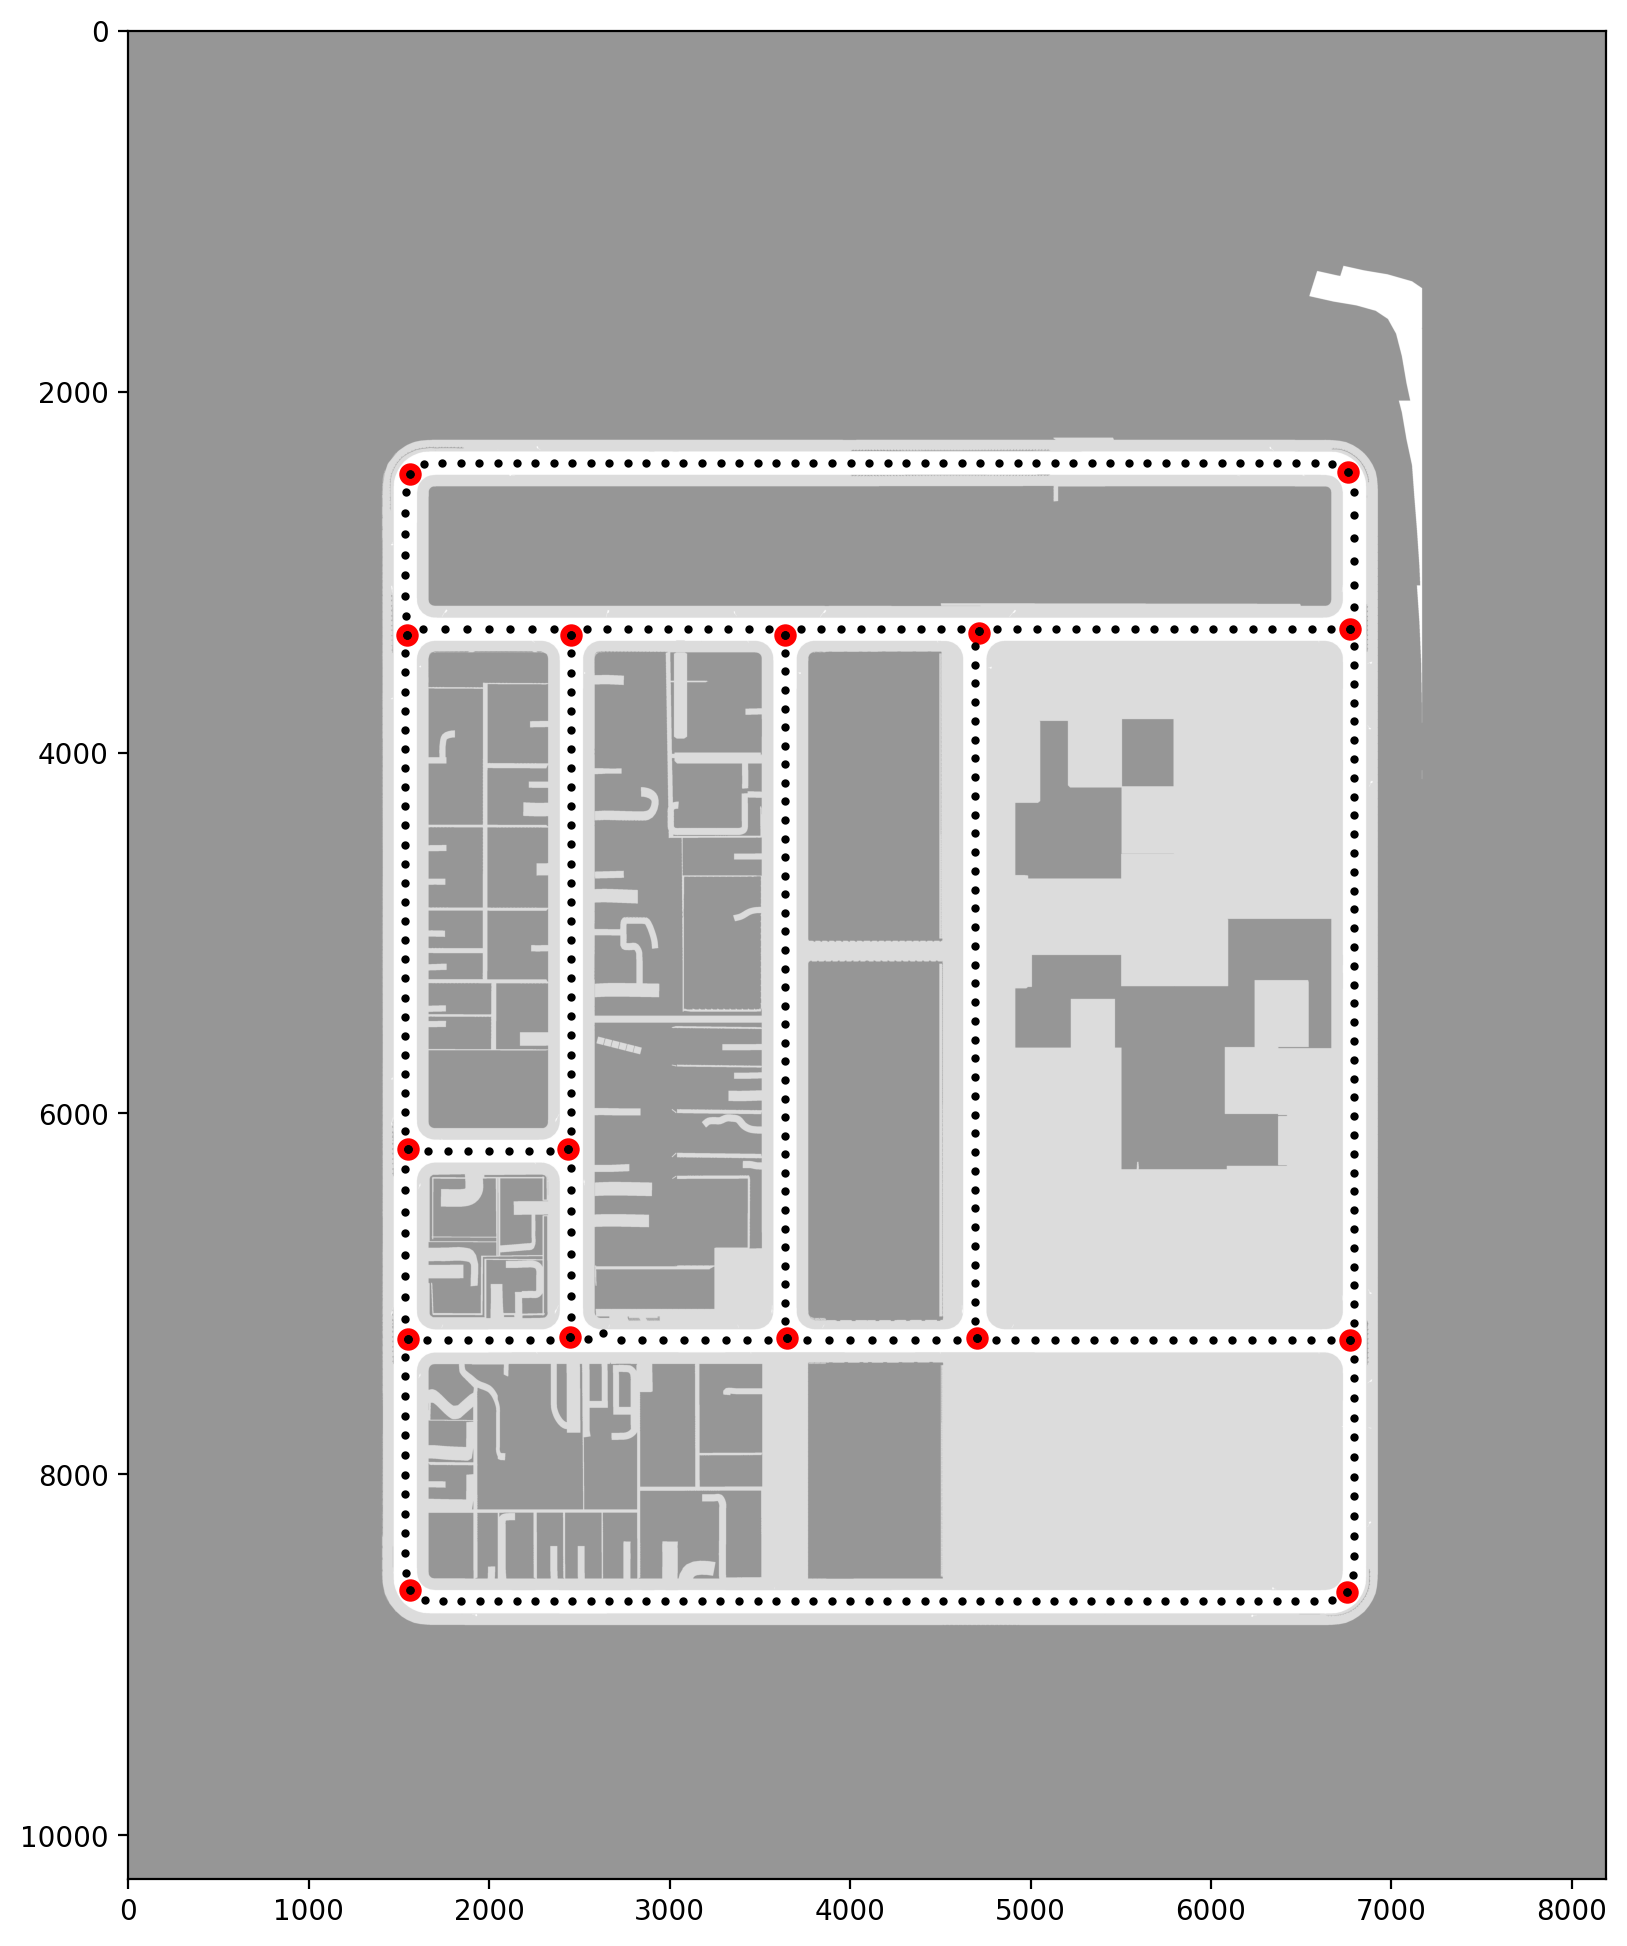

In [14]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for (i, j), waypoints in edge_waypoints.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'k.', markersize=4)

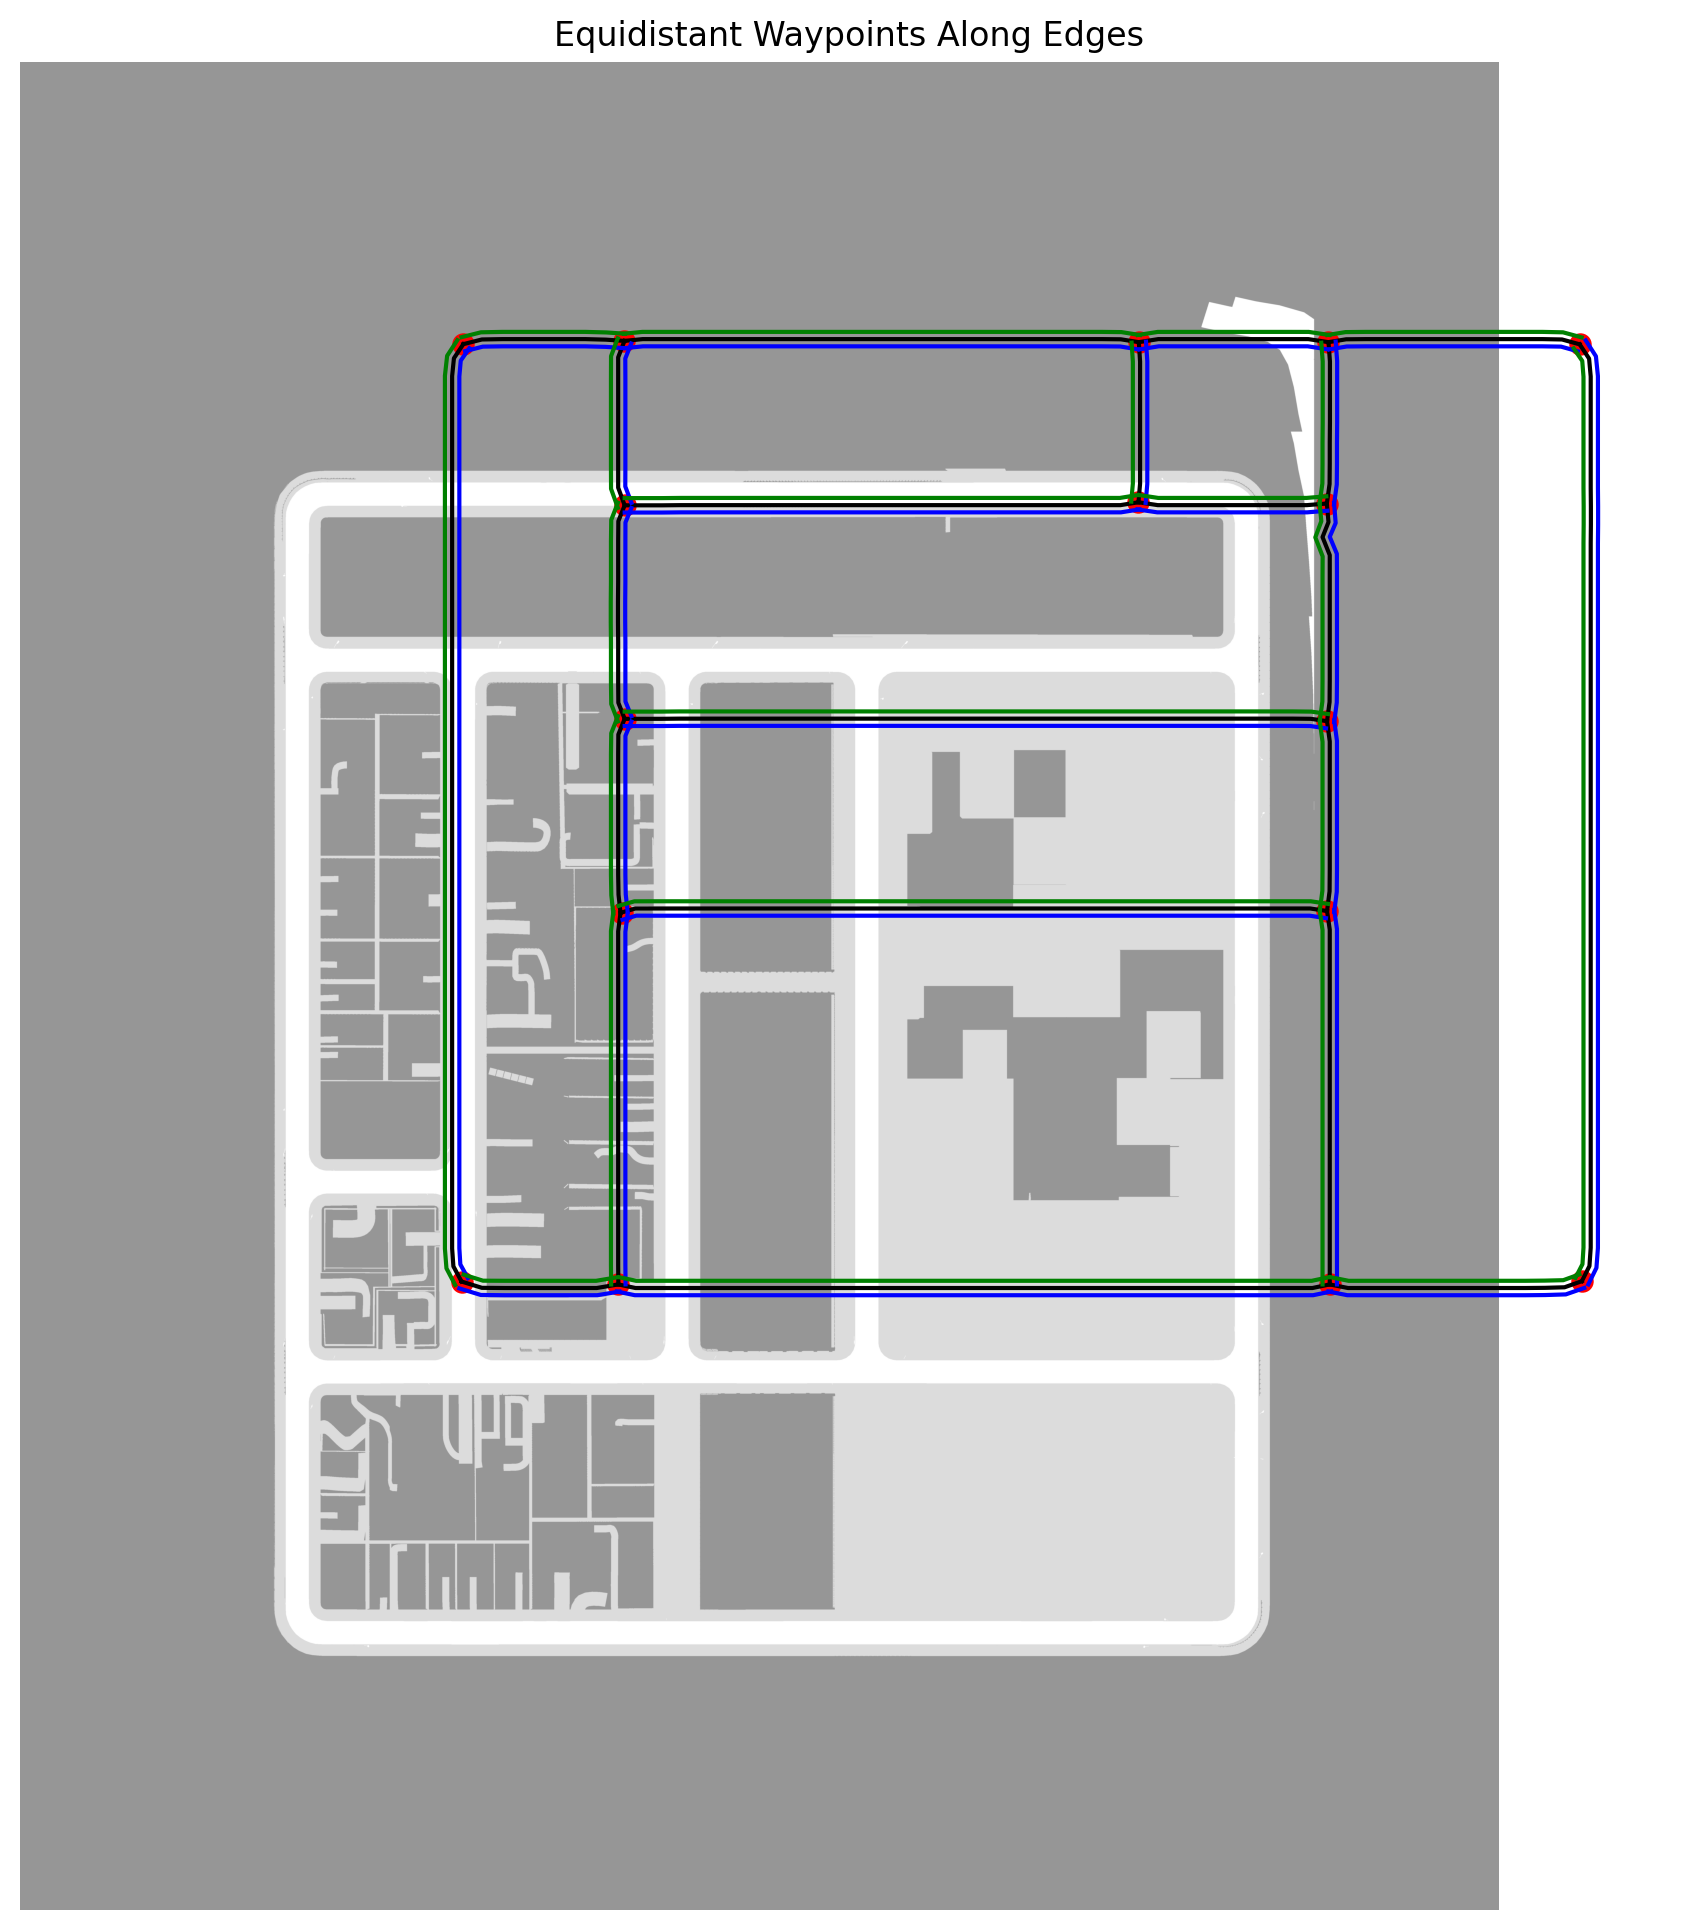

In [15]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[1], p[0], c='red', s=50)

for (i, j), waypoints in edge_waypoints.items():
    plt.plot(waypoints[:,1], waypoints[:,0], 'k-', markersize=4)

for (i, j), waypoints in edge_lanes_l.items():
    plt.plot(waypoints[:,1], waypoints[:,0], 'b-', markersize=4)

for (i, j), waypoints in edge_lanes_r.items():
    plt.plot(waypoints[:,1], waypoints[:,0], 'g-', markersize=4)

plt.title("Equidistant Waypoints Along Edges")
plt.axis('off')
plt.show()

In [17]:
def add_center_waypoints(G, edge_id, centerline, cost_forward=1.0, cost_to_intersection=0.1):
    """
    Adds centerline waypoints and connects them to intersection nodes.
    
    Parameters:
        G : networkx.Graph
            The planning graph to modify.
        edge_id : tuple
            A pair of intersection indices (i, j).
        centerline : list of (x, y)
            Waypoints along the road between i and j.
        cost_forward : float
            Cost of traveling forward along the centerline.
        cost_to_intersection : float
            Cost of entering or exiting an intersection.
    """
    edge_label = f"{edge_id[0]}-{edge_id[1]}"
    N = len(centerline)

    for i in range(N):
        c_node = f"{edge_label}_C_{i}"
        G.add_node(c_node, pos=centerline[i], lane="center")

        if i < N - 1:
            next_node = f"{edge_label}_C_{i+1}"
            G.add_edge(c_node, next_node, cost=cost_forward)

    # --- Connect endpoints to intersections ---
    start_node = f"{edge_label}_C_0"
    end_node = f"{edge_label}_C_{N-1}"

    start_intersection = f"intersection_{edge_id[0]}"
    end_intersection = f"intersection_{edge_id[1]}"

    G.add_node(start_intersection, pos=centerline[0], lane="intersection")
    G.add_node(end_intersection, pos=centerline[-1], lane="intersection")

    G.add_edge(start_intersection, start_node, cost=cost_to_intersection)
    G.add_edge(start_node, start_intersection, cost=cost_to_intersection)

    G.add_edge(end_intersection, end_node, cost=cost_to_intersection)
    G.add_edge(end_node, end_intersection, cost=cost_to_intersection)

    return G


In [69]:
# --- Function to add waypoints and lane mesh to G_planning ---
def add_lane_waypoints_to_graph(G, edge_id, centerline, left_lane, right_lane,
                                connect_lateral=True,
                                connect_diagonal=False,
                                cost_forward=1.0,
                                cost_lateral=3.0,
                                cost_diagonal=5.0):
    N = len(centerline)
    edge_label = f"{edge_id[0]}-{edge_id[1]}"

    for i in range(N):
        c_node = f"{edge_label}_C_{i}"
        l_node = f"{edge_label}_L_{i}"
        r_node = f"{edge_label}_R_{i}"

        G.add_node(c_node, pos=tuple(centerline[i]), lane="center")
        G.add_node(l_node, pos=tuple(left_lane[i]), lane="left")
        G.add_node(r_node, pos=tuple(right_lane[i]), lane="right")

        if i < N - 1:
            G.add_edge(c_node, f"{edge_label}_C_{i+1}", cost=cost_forward)
            G.add_edge(l_node, f"{edge_label}_L_{i+1}", cost=cost_forward)
            G.add_edge(r_node, f"{edge_label}_R_{i+1}", cost=cost_forward)

        if connect_lateral:
            G.add_edge(c_node, l_node, cost=cost_lateral)
            G.add_edge(c_node, r_node, cost=cost_lateral)
            G.add_edge(l_node, c_node, cost=cost_lateral)
            G.add_edge(r_node, c_node, cost=cost_lateral)

        if connect_diagonal and i < N - 1:
            G.add_edge(l_node, f"{edge_label}_C_{i+1}", cost=cost_diagonal)
            G.add_edge(r_node, f"{edge_label}_C_{i+1}", cost=cost_diagonal)

In [18]:
def get_closest_node(graph, point):
    # Assume graph nodes are (x, y) tuples
    return min(graph.nodes, key=lambda n: (n[0] - point[0])**2 + (n[1] - point[1])**2)


In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Parameters ---
lane_width_pixels = 80  # Adjust to your map's scale
sample_step = 100       # Step size for waypoint sampling
add_lanes = False

# --- Containers ---
edge_waypoints = {}
edge_lanes_r = {}
edge_lanes_l = {}

# --- Full planning graph ---
G_planning = G_intersections.copy()

# --- Main loop ---
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]

    # Get path in pixel_graph and sample waypoints
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(path, step=sample_step)

    # Compute lane offsets
    left_lane, right_lane, _, _ = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)

    # Save for visualization/debugging
    edge_waypoints[(i, j)] = waypoints
    edge_lanes_l[(i, j)] = left_lane
    edge_lanes_r[(i, j)] = right_lane

    add_center_waypoints(G_planning, edge_id=(i,j), centerline=waypoints)

    # After building each segment of waypoints for an edge (i, j):
    last_c = f"{i}-{j}_C_{len(waypoints)-1}"

    # For all other edges connected to 'j'
    for neighbor in G_intersections.neighbors(j):
        if neighbor == i:
            continue
        neighbor_edge = (j, neighbor)
        neighbor_waypoints = edge_waypoints.get(neighbor_edge) or edge_waypoints.get((neighbor, j))
        if neighbor_waypoints is None:
            continue
        first_neighbor_c = f"{j}-{neighbor}_C_0"
        G_planning.add_edge(last_c, first_neighbor_c, cost=1.0)  # You can tune the cost


In [22]:
merge_threshold = 10
# --- Merge redundant nodes ---
pos = nx.get_node_attributes(G_planning, 'pos')
positions = list(pos.items())

for i in range(len(positions)):
    node_i, pos_i = positions[i]
    for j in range(i+1, len(positions)):
        node_j, pos_j = positions[j]
        if np.linalg.norm(np.array(pos_i) - np.array(pos_j)) < merge_threshold:
            # Merge node_j into node_i
            if node_j in G_planning and node_i in G_planning:
                nx.relabel_nodes(G_planning, {node_j: node_i}, copy=False)

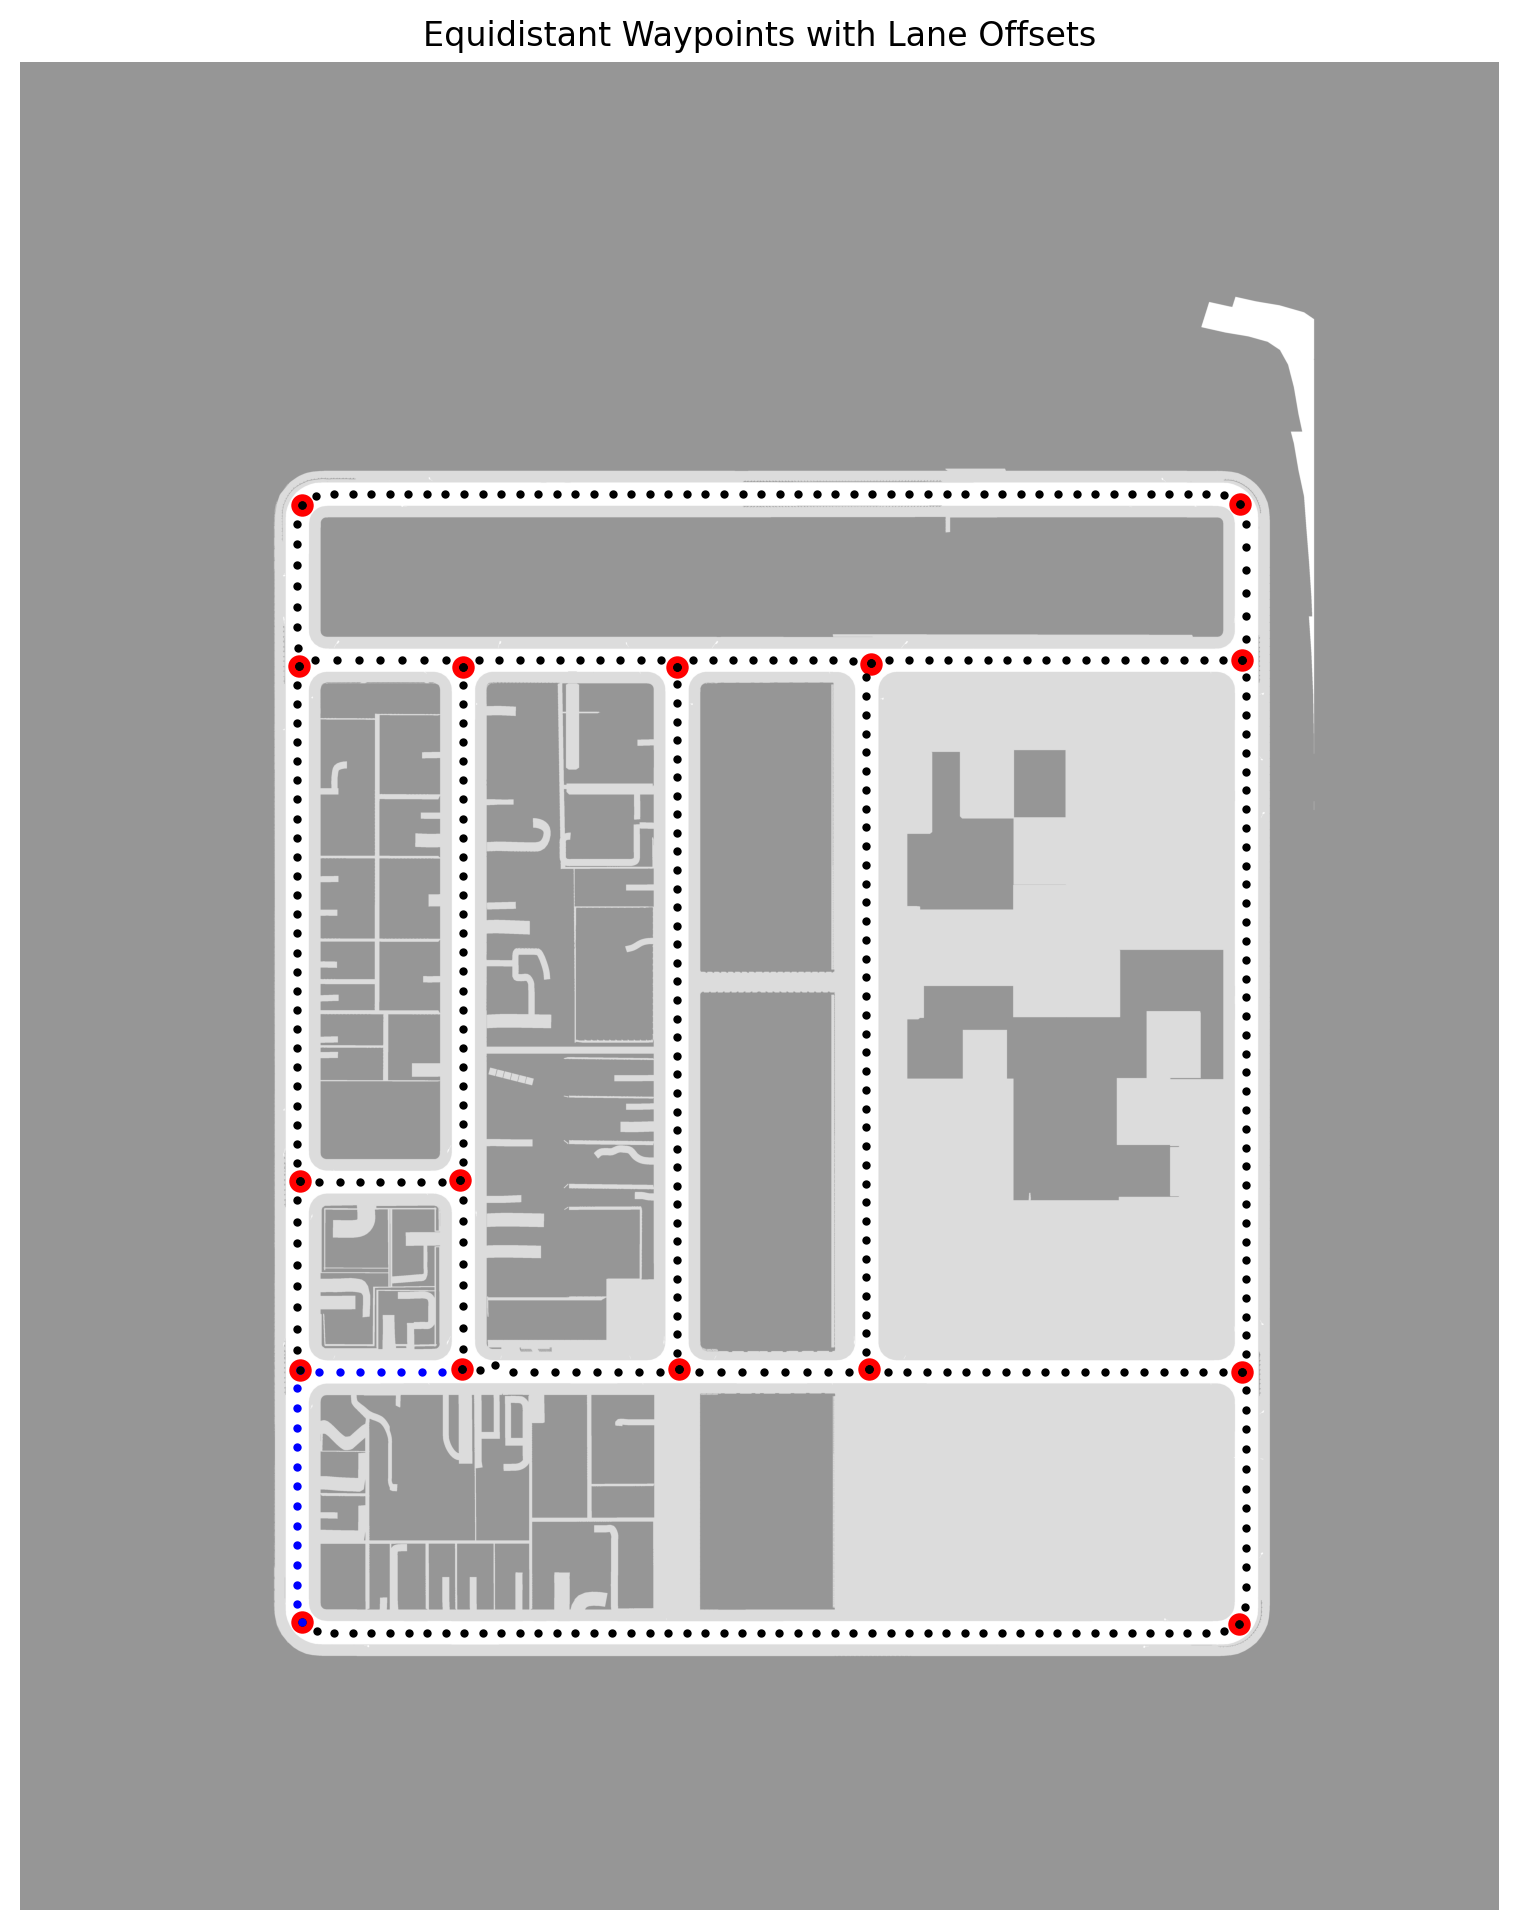

In [41]:
# --- Optional: Visualization ---
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for (i, j), waypoints in edge_waypoints.items():
    color = 'k.'
    if (i, j) == (0, 2) or (i, j) == (2, 3):
        color = 'b.'
    plt.plot(waypoints[:,0], waypoints[:,1], color, markersize=4)
"""
for (i, j), waypoints in edge_lanes_l.items():
    plt.plot(waypoints[:,1], waypoints[:,0], 'b-', linewidth=1)

for (i, j), waypoints in edge_lanes_r.items():
    plt.plot(waypoints[:,1], waypoints[:,0], 'g-', linewidth=1)
"""


plt.title("Equidistant Waypoints with Lane Offsets")
plt.axis('off')
plt.show()

NetworkXError: Node '6-1_C_0' has no position.

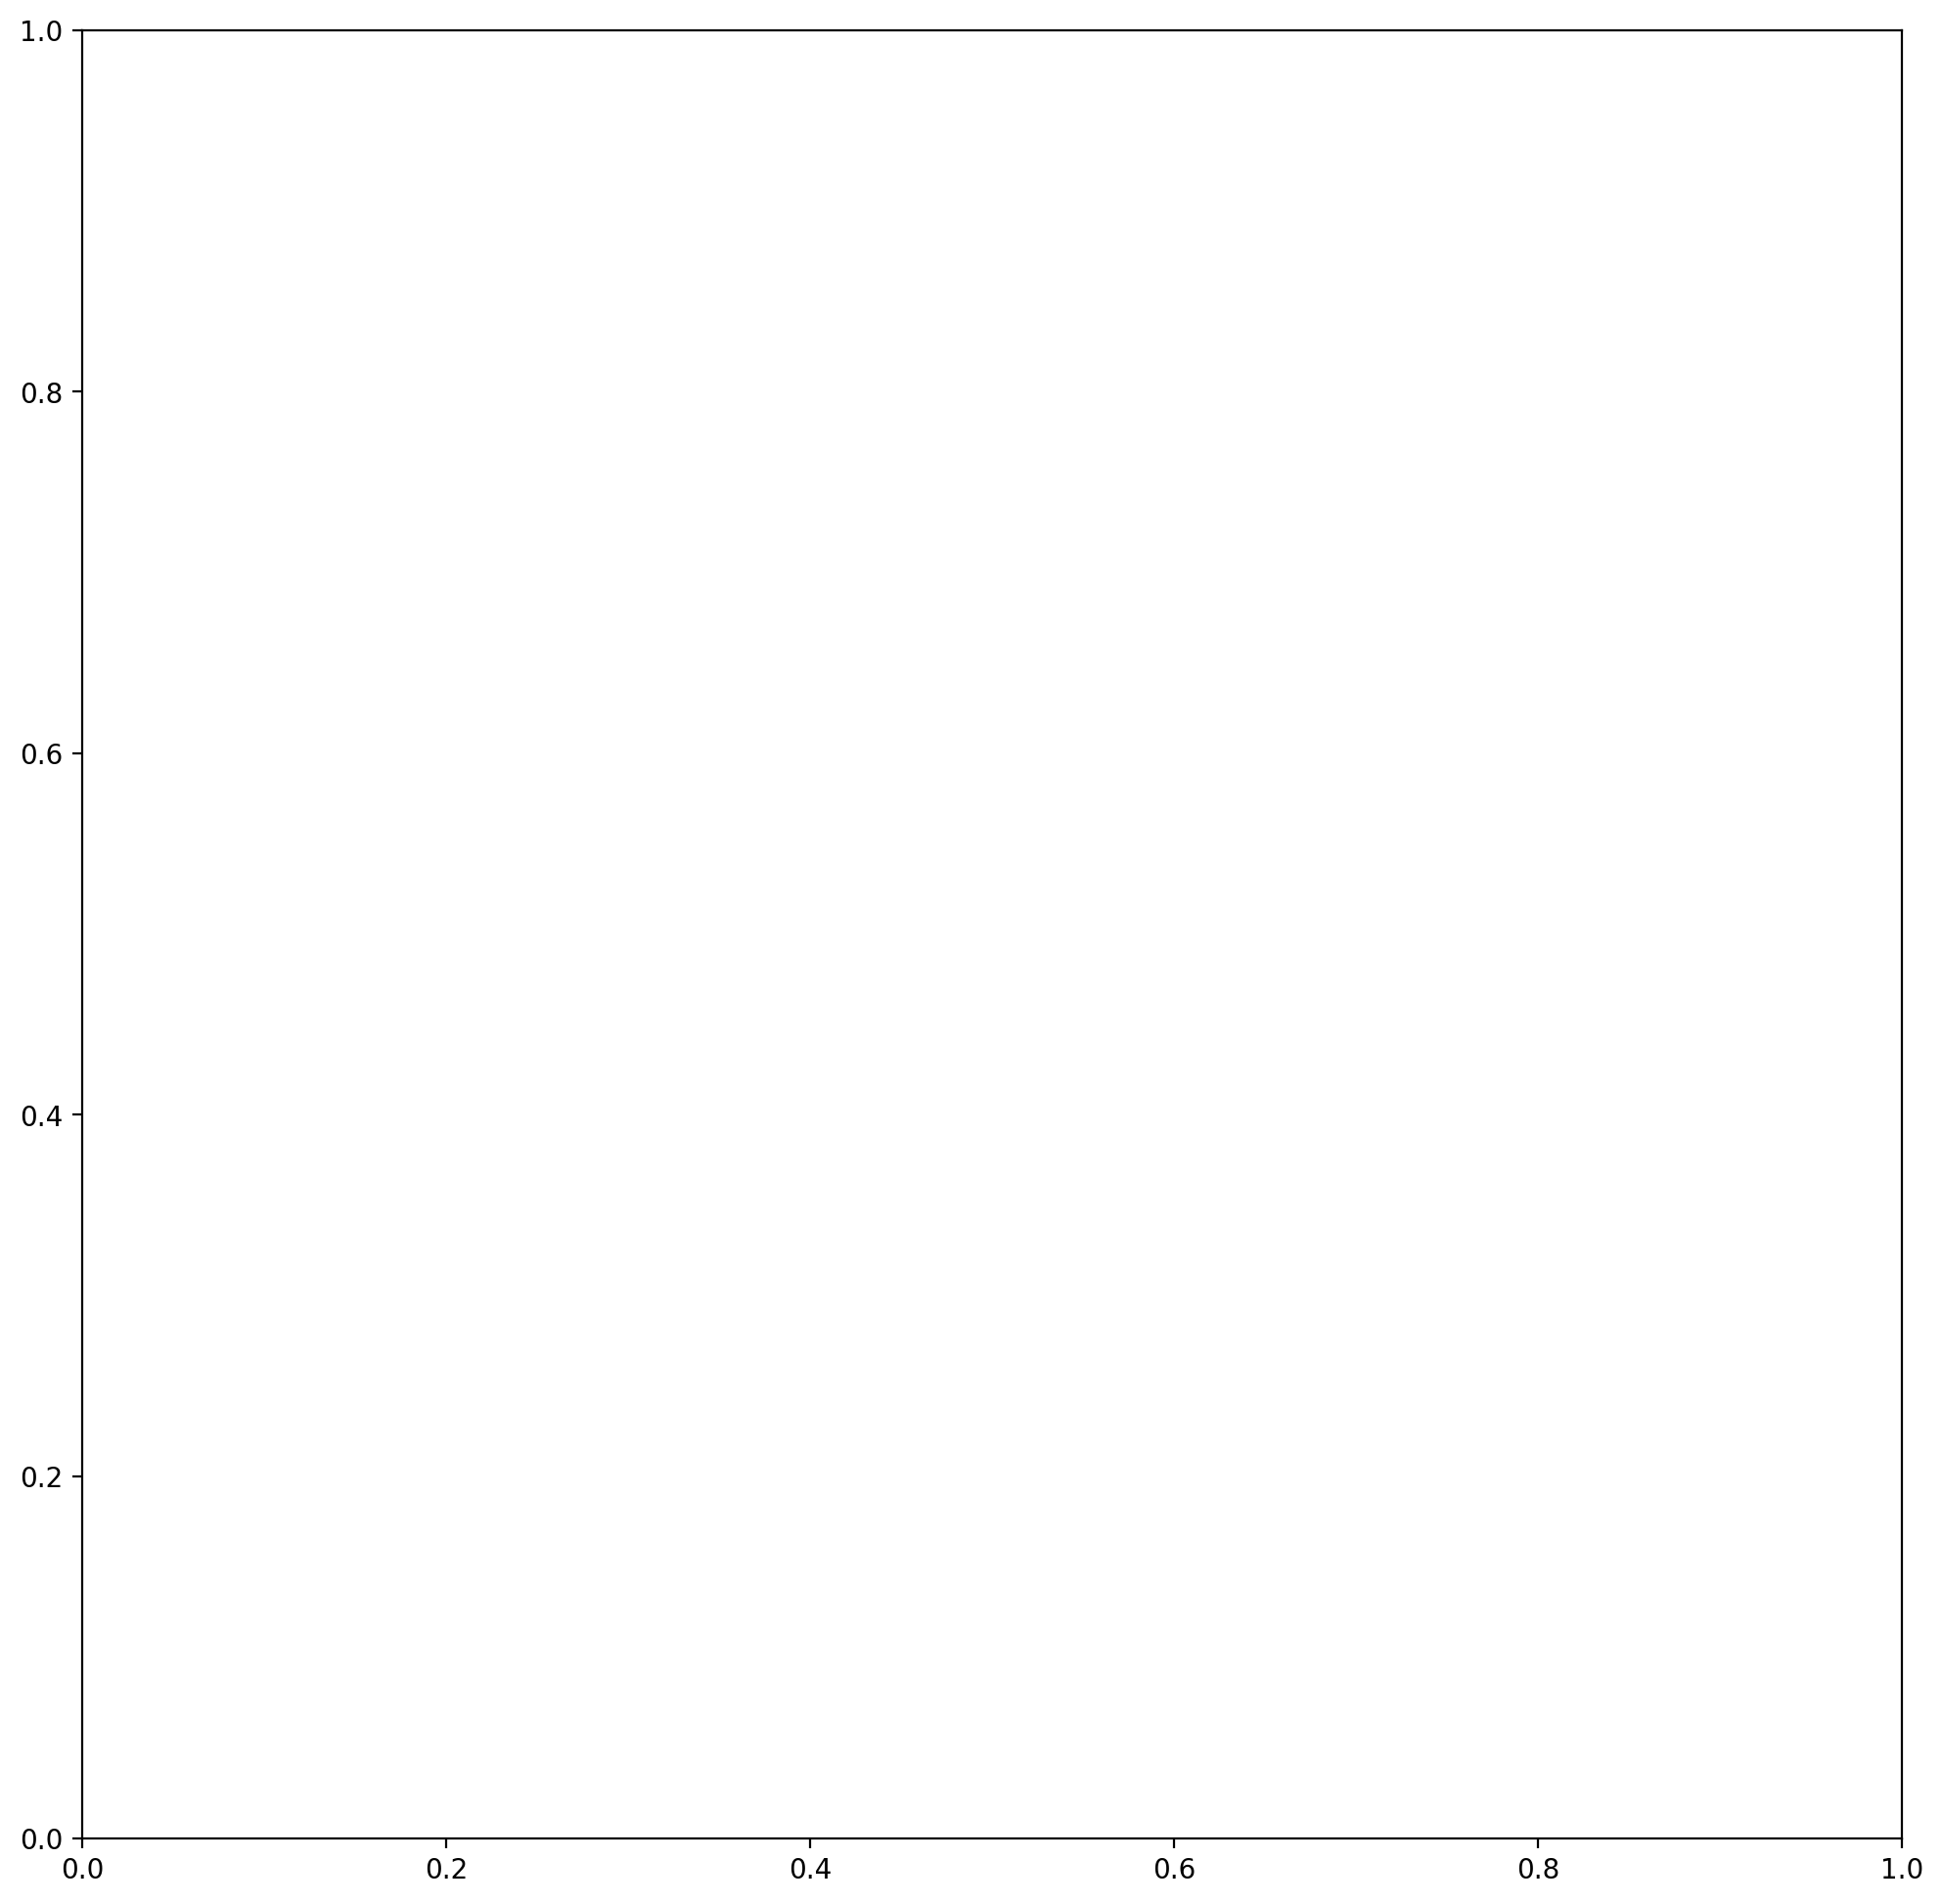

In [24]:
# --- Draw the planning graph with nx.draw_networkx() ---
pos = nx.get_node_attributes(G_planning, 'pos')
plt.figure(figsize=(12, 12))
nx.draw_networkx(G_planning, pos=pos, node_size=10, with_labels=False, edge_color='gray')
plt.title("Lane-level Planning Graph")
plt.axis('equal')
plt.show()

In [42]:
import pickle

# Save
with open("town01_centerline.pkl", "wb") as f:
    pickle.dump(G_planning, f)

# Load
with open("town01_centerline.pkl", "rb") as f:
    G_planning = pickle.load(f)


In [25]:
def get_node_pos(graph, node_id):
    pos = np.array(graph.nodes[node_id]['pos'], dtype=np.int32)
    return pos

def parse_node_label(label):
    """Parses a node label like '10-8_C_0' into i, j, lane, and n (as integers or strings)."""
    edge_part, lane, n = label.split('_')
    i, j = map(int, edge_part.split('-'))
    n = int(n)
    return i, j, lane, n


In [26]:
G_planning.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, '0-1_C_1', '0-1_C_2', '0-1_C_3', '0-1_C_4', '0-1_C_5', '0-1_C_6', '0-1_C_7', '0-1_C_8', '0-1_C_9', '0-1_C_10', '0-1_C_11', '0-1_C_12', '0-1_C_13', '0-1_C_14', '0-1_C_15', '0-1_C_16', '0-1_C_17', '0-1_C_18', '0-1_C_19', '0-1_C_20', '0-1_C_21', '0-1_C_22', '0-1_C_23', '0-1_C_24', '0-1_C_25', '0-1_C_26', '0-1_C_27', '0-1_C_28', '0-1_C_29', '0-1_C_30', '0-1_C_31', '0-1_C_32', '0-1_C_33', '0-1_C_34', '0-1_C_35', '0-1_C_36', '0-1_C_37', '0-1_C_38', '0-1_C_39', '0-1_C_40', '0-1_C_41', '0-1_C_42', '0-1_C_43', '0-1_C_44', '0-1_C_45', '0-1_C_46', '0-1_C_47', '0-1_C_48', '0-1_C_49', '0-1_C_50', '0-2_C_1', '0-2_C_2', '0-2_C_3', '0-2_C_4', '0-2_C_5', '0-2_C_6', '0-2_C_7', '0-2_C_8', '0-2_C_9', '0-2_C_10', '0-2_C_11', '0-2_C_12', '1-6_C_1', '1-6_C_2', '1-6_C_3', '1-6_C_4', '1-6_C_5', '1-6_C_6', '1-6_C_7', '1-6_C_8', '1-6_C_9', '1-6_C_10', '1-6_C_11', '1-6_C_12', '2-3_C_1', '2-3_C_2', '2-3_C_3', '2-3_C_4', '2-3_C_5', '2-3_C_6', '2-3_C_7'

In [27]:
for i in range(16):
    try:
        G_planning.remove_node(i)
    except:
        print(i)

In [28]:
import random 

def display_random_route_from_waypoints(G_planning, rgbmap, min_distance=1000, max_distance=3000):
    pos = nx.get_node_attributes(G_planning, 'pos')
    # Filter to only centerline nodes
    waypoint_nodes = [n for n in G_planning.nodes if isinstance(n, str) and "_C_" in n]

    random.shuffle(waypoint_nodes)

    while True:
        start = random.choice(waypoint_nodes)
        end = random.choice(waypoint_nodes)
        if start == end:
            continue
        try:
            i, j, lane, k = parse_node_label(start)
            p1 = np.array([pos[start]])
        except:
            start = f'{j}-{i}_{lane}_{k}'

        try:
            i, j, lane, k = parse_node_label(end)
            p2 = np.array([pos[end]])
        except:
            end = f'{j}-{i}_{lane}_{k}'
            
        dist = np.linalg.norm(p1 - p2)

        if min_distance <= dist <= max_distance:
            try:
                path = nx.shortest_path(G_planning, start, end, weight='cost')
                coords = np.array([pos[n] for n in path])
                break
            except nx.NetworkXNoPath:
                continue

    # --- Visualization ---
    plt.figure(figsize=(10, 10))
    plt.imshow(rgbmap)
    plt.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=2)
    plt.scatter(coords[:, 0], coords[:, 1], c='k', s=10)
    plt.scatter([coords[0, 0], coords[-1, 0]], [coords[0, 1], coords[-1, 1]], c=['green', 'red'], s=60)
    plt.title("Random Route Between Waypoints (Multi-turn)")
    plt.axis('off')
    plt.show()


In [29]:
display_random_route_from_waypoints(G_planning, rgbmap)


NodeNotFound: Either source 5-6_C_5 or target 5-12_C_0 is not in G

In [55]:
import random 

# --- Function to generate and display a random route ---
def display_random_route(G, pos, rgbmap, min_distance=100, max_distance=1000):
    nodes = list(pos.keys())
    random.shuffle(nodes)
    while True:
        start = random.choice(nodes)
        end = random.choice(nodes)
        if start != end:
            p1 = np.array(pos[start])
            p2 = np.array(pos[end])
            dist = np.linalg.norm(p1 - p2) 
            if dist > min_distance and dist < max_distance:
                try:
                    path = nx.shortest_path(G, start, end, weight='cost')
                    coords = np.array([pos[n] for n in path])
                    break
                except nx.NetworkXNoPath:
                    continue

    plt.figure(figsize=(10, 10))
    plt.imshow(rgbmap)
    plt.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=2)
    for coord in coords:
        plt.scatter(coord[0], coord[1], c='k', s=10)
    plt.scatter([coords[0, 0], coords[-1, 0]], [coords[0, 1], coords[-1, 1]], c=['green', 'red'], s=60)
    plt.title("Random Route on Lane-level Planning Graph")
    plt.axis('off')
    plt.show()

# --- Display one random route ---

pos = nx.get_node_attributes(G_planning, 'pos')
display_random_route(G_planning, pos, rgbmap, min_distance=1000, max_distance=3000)

In [31]:
def visualize_planning_routes(G_intersections, G_planning, intersection_nodes, rgbmap=None):
    """
    Visualizes intersection connections and the waypoint-based centerline routes from G_planning.

    Args:
        G_intersections: Coarse graph of intersections (node IDs are ints)
        G_planning: Fine-grained planning graph with waypoints
        intersection_nodes: dict {node_id: (x, y)} of intersection coordinates
        rgbmap: Optional image background
    """
    pos_planning = nx.get_node_attributes(G_planning, 'pos')

    plt.figure(figsize=(12, 12))
    if rgbmap is not None:
        plt.imshow(rgbmap)

    # --- Plot intersection nodes ---
    for node_id, pos in intersection_nodes.items():
        plt.scatter(pos[0], pos[1], c='red', s=50)
        plt.text(pos[0]+5, pos[1]+5, str(node_id), fontsize=8, color='white')

    # --- Plot intersection edges ---
    for i, j in G_intersections.edges:
        a = intersection_nodes[i]
        b = intersection_nodes[j]
        plt.plot([a[0], b[0]], [a[1], b[1]], 'orange', linestyle='--', linewidth=1, label='Intersections' if i == 0 and j == 1 else None)

    # --- Plot waypoint-based centerline routes ---
    seen_edges = set()
    for node in G_planning.nodes:
        if isinstance(node, str) and '_C_' in node:
            edge_prefix = node.split('_C_')[0]
            if edge_prefix not in seen_edges:
                seen_edges.add(edge_prefix)

                # Collect and sort all centerline nodes for this edge
                center_nodes = [n for n in G_planning.nodes
                                if isinstance(n, str) and n.startswith(edge_prefix + '_C_')]

                center_nodes_sorted = sorted(center_nodes, key=lambda n: int(n.split('_C_')[1]))

                points = [pos_planning[n] for n in center_nodes_sorted if n in pos_planning]
                if len(points) > 1:
                    points = np.array(points)
                    plt.plot(points[:,0], points[:,1], 'cyan', linewidth=2, label='Waypoint Route' if len(seen_edges) == 1 else None)

    plt.title("Intersection-to-Intersection Waypoint Routes")
    plt.axis('off')
    plt.legend()
    plt.show()


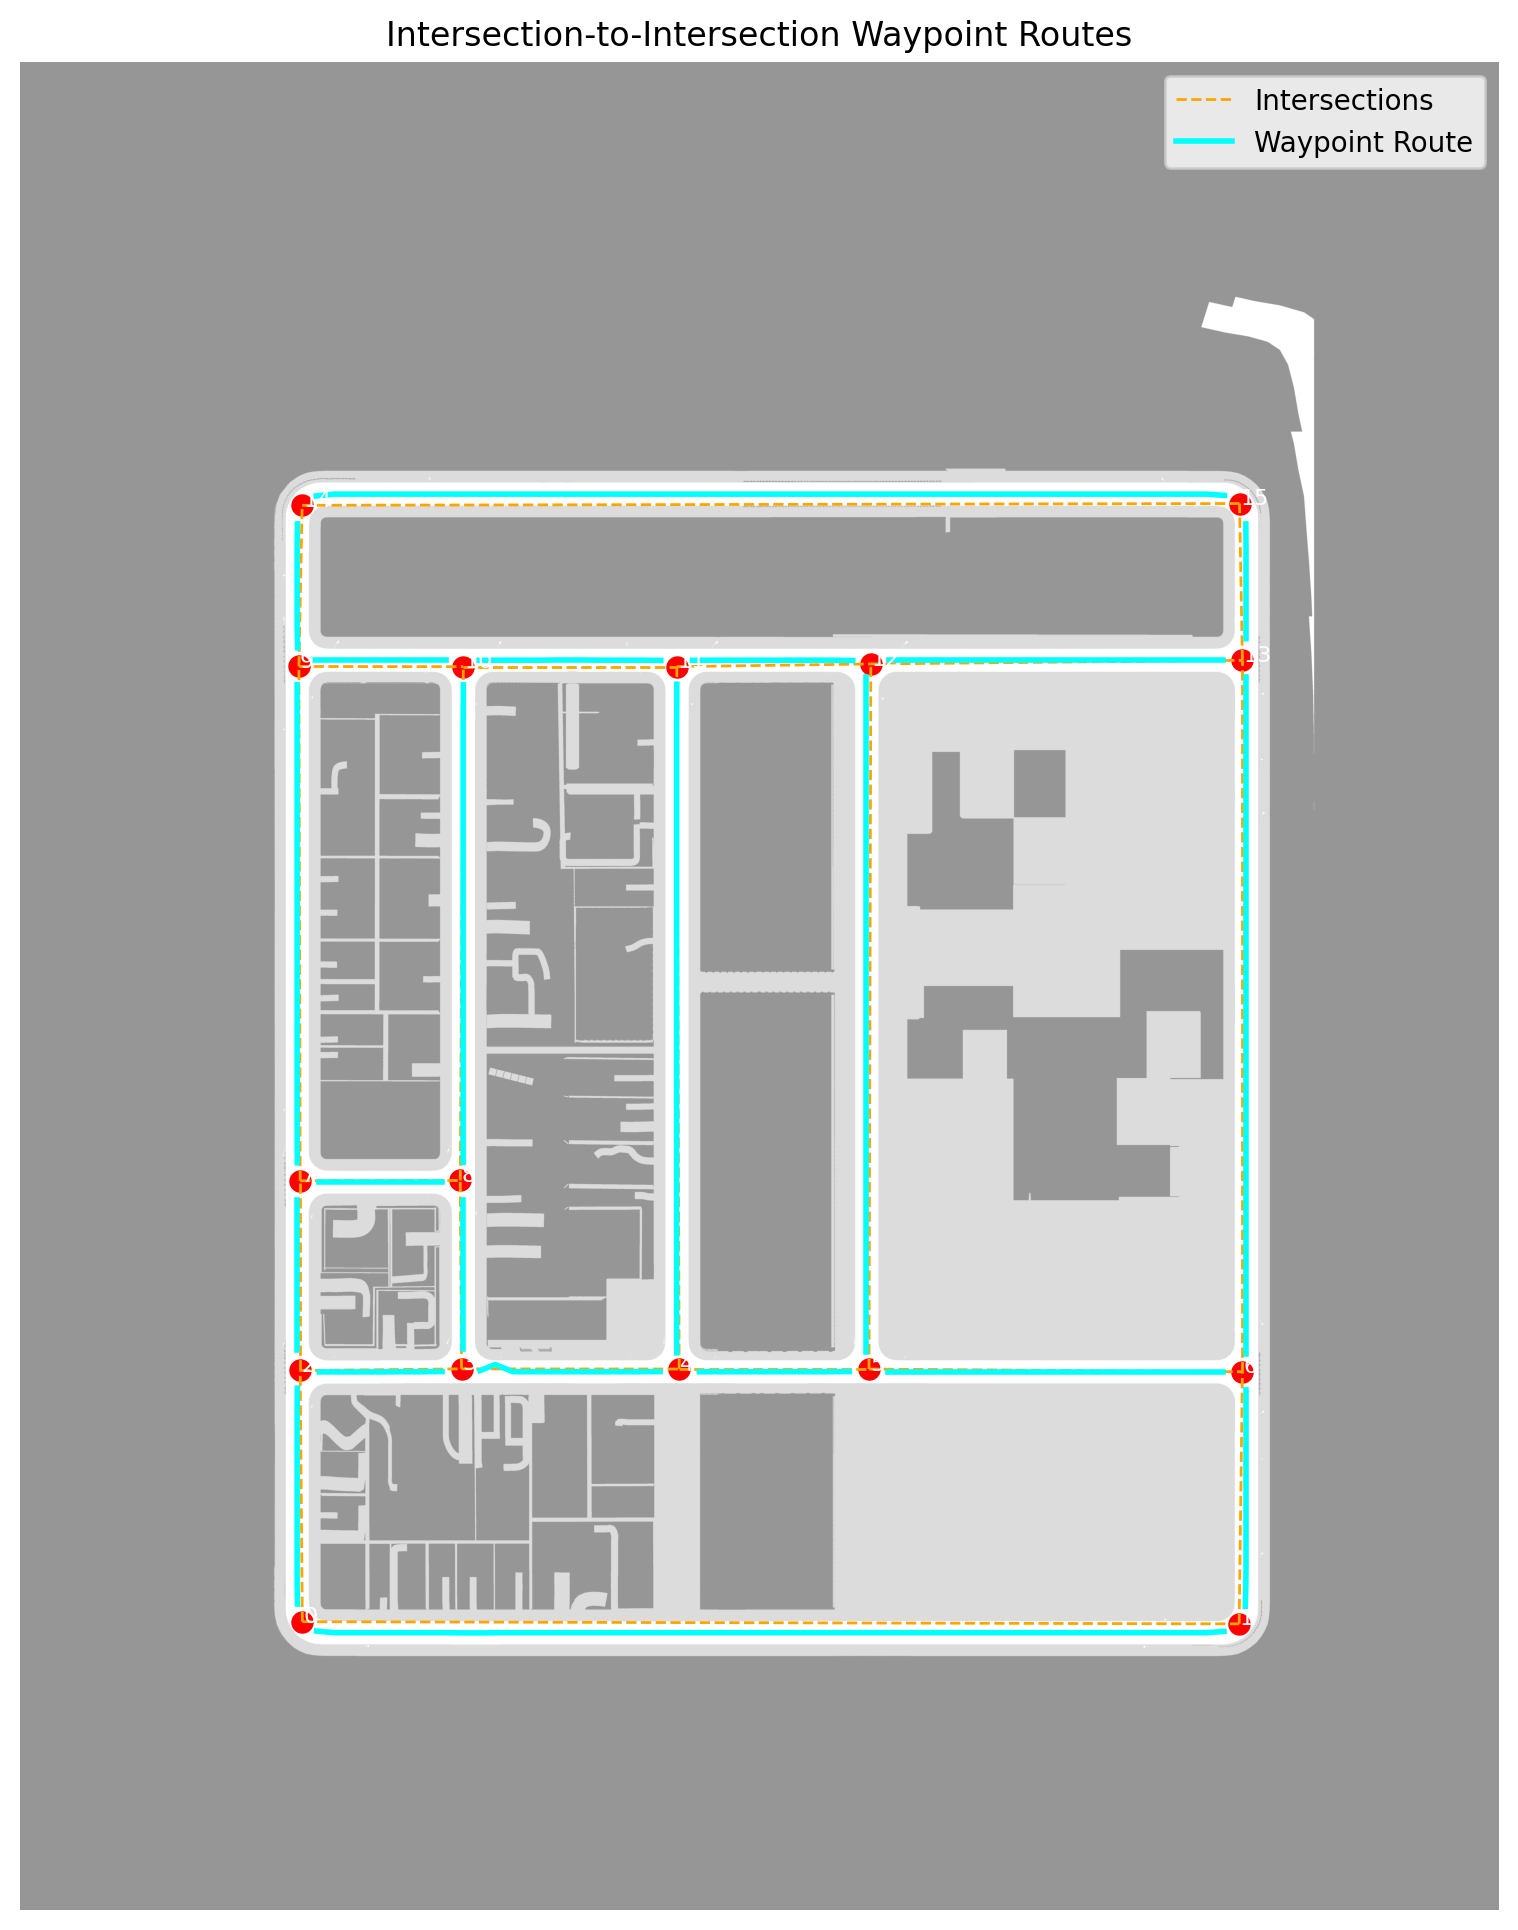

In [32]:
intersection_nodes = nx.get_node_attributes(G_intersections, 'pos')

visualize_planning_routes(G_intersections, G_planning, intersection_nodes, rgbmap=rgbmap)

In [33]:
import random
import numpy as np


def plot_route_on_map(merged_path_coords):
    """
    Plots the route on top of the map.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(rgbmap)
    
    # Draw route
    if merged_path_coords.shape[0] > 1:
        plt.plot(merged_path_coords[:, 1], merged_path_coords[:, 0], 'r-', linewidth=3, label='Route')
        plt.scatter(merged_path_coords[0, 1], merged_path_coords[0, 0], c='green', s=100, label='Start')
        plt.scatter(merged_path_coords[-1, 1], merged_path_coords[-1, 0], c='red', s=100, label='End')

    plt.title("Shortest Path on Lane: Merged Route")
    plt.legend()
    plt.axis('off')
    plt.show()


In [34]:
from CarlaBEV.src.planning.graph_planner import GraphPlanner
from CarlaBEV.envs.utils import scale_coords, scale_route

map_graph = GraphPlanner(graph_path='town01_centerline.pkl')

In [35]:
def debug(map_graph, min_distance=500, max_distance=1000):
    nodes = [n for n, data in map_graph.G.nodes(data=True) if data.get('lane') == 'center']
    random.shuffle(nodes)

    # Try pairs until we find a valid one
    for source in nodes:
        pos_source = np.array(map_graph.G.nodes[source]['pos'])
        for target in nodes:
            if source == target:
                continue
        
            pos_target = np.array(map_graph.G.nodes[target]['pos'])
            dist = np.linalg.norm(pos_source - pos_target)
            if dist > min_distance and dist < max_distance:
                try:
                    path = nx.shortest_path(map_graph.G, source=source, target=target, weight='cost')
                    #merged_path = self.merge_close_nodes(path, threshold=merge_threshold)
                    return path 
                except nx.NetworkXNoPath:
                    continue
    print("No valid route found.")
    return None, None





In [36]:
debug(map_graph)

['5-12_C_3',
 '5-12_C_2',
 '5-12_C_1',
 '5-12_C_0',
 'intersection_5',
 '5-6_C_0',
 '5-6_C_1',
 '5-6_C_2',
 '5-6_C_3',
 '5-6_C_4',
 '5-6_C_5',
 '5-6_C_6',
 '5-6_C_7']

In [37]:

def preproc_route(map_graph, path_ids):
    rx, ry = [], []
    for nodeid in path_ids:
        pos = map_graph.get_node_pos(nodeid)
        rx.append(pos[1])
        ry.append(pos[0])
    return (rx, ry)

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def parse_node_label(label):
    edge_part, lane, n = label.split('_')
    i, j = map(int, edge_part.split('-'))
    return i, j, lane, int(n)

def get_centerline_nodes(G):
    return [n for n, d in G.nodes(data=True) if d.get("lane") == "center"]

def find_random_turning_nodes(G, intersection_pairs):
    center_nodes = get_centerline_nodes(G)
    tries = 0
    max_tries = 1000

    while tries < max_tries:
        # Choose two edge pairs that share an intersection
        i1, j1 = random.choice(intersection_pairs)
        neighbors = [pair for pair in intersection_pairs if i1 in pair or j1 in pair]
        neighbors = [pair for pair in neighbors if pair != (i1, j1)]
        if not neighbors:
            tries += 1
            continue
        i2, j2 = random.choice(neighbors)

        # Build edge labels
        edge1_label = f"{i1}-{j1}_C_"
        edge2_label = f"{i2}-{j2}_C_"

        # Filter center nodes from those edges
        nodes1 = [n for n in center_nodes if n.startswith(edge1_label)]
        nodes2 = [n for n in center_nodes if n.startswith(edge2_label)]

        if nodes1 and nodes2:
            start_node = random.choice(nodes1)
            end_node = random.choice(nodes2)
            if start_node != end_node:
                try:
                    path = nx.shortest_path(G, start_node, end_node, weight='cost')
                    return path
                except nx.NetworkXNoPath:
                    pass

        tries += 1
    raise ValueError("Failed to find a valid turning path after many attempts.")

# === Usage ===
intersection_pairs = [(0, 1), (0, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8),
                      (4, 5), (4, 11), (5, 6), (5, 12), (6, 13), (7, 8), (7, 9),
                      (8, 10), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13),
                      (13, 15), (14, 15)]

# Generate path
path = find_random_turning_nodes(G_planning, intersection_pairs)
pos = nx.get_node_attributes(G_planning, 'pos')
coords = np.array([pos[n] for n in path])

# Display route
plt.figure(figsize=(10, 10))
plt.imshow(rgbmap)
plt.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=2)
plt.scatter(coords[:, 0], coords[:, 1], c='k', s=10)
plt.scatter([coords[0, 0], coords[-1, 0]], [coords[0, 1], coords[-1, 1]], c=['green', 'red'], s=60)
plt.title("Random Route with Turn on Lane-level Graph")
plt.axis('off')
plt.show()


ValueError: Failed to find a valid turning path after many attempts.